In [1]:
%load_ext autoreload
%autoreload 2
from dds.configs.config import set_task, get_config
from dds.train_dds import train_dds
import numpy as onp
import jax

import distrax
import jax.numpy as jnp
import haiku as hk
from jaxline import utils

import functools
import timeit
from typing import Any, List, Tuple, Optional
from absl import app, flags

from absl import logging
import haiku as hk
import distrax
import jax
import jax.numpy as jnp

from ml_collections import config_dict as configdict
from ml_collections import config_flags

import numpy as onp
import optax

from jaxline import utils

from dds.configs.config import set_task
from dds.data_paths import results_path
from dds.utils import flatten_nested_dict
import wandb
print(jax.devices())

2023-08-15 20:06:10.011555: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-08-15 20:06:10.011644: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-08-15 20:06:10.011652: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


[StreamExecutorGpuDevice(id=0, process_index=0, slice_index=0)]


In [2]:
from dds.objectives import controlled_ais_relative_kl_objective
from dds.objectives import controlled_ais_importance_weighted_partition_estimate_dds


config = get_config()

# Time and step settings (Need to be done before calling set_task)
config.model.tfinal = 6.4
# config.model.tfinal = 10
config.model.dt = 0.05

config.model.reference_process_key = "cais"

config.trainer.objective = controlled_ais_relative_kl_objective
config.trainer.lnz_is_estimator = controlled_ais_importance_weighted_partition_estimate_dds

if config.model.reference_process_key == "oudstl":
    config.model.step_scheme_key = "cos_sq"

config = set_task(config, "lr_sonar")

if config.model.reference_process_key == "oudstl":
    config.model.step_scheme_key = "cos_sq"
    
    # Opt setting for funnel
    config.model.sigma = 1.
    config.model.alpha = 0.6875
    config.model.m = 1.0
        
    # Path opt settings    
    config.model.exp_dds = False

if config.model.reference_process_key == "cais":
    config.model.step_scheme_key = "linear"
    
    # Opt setting for funnel
    config.model.alpha = 0.6875
    config.model.m = 1.0
        
    # Path opt settings    
    config.model.exp_dds = False
    config.trainer.lr_sch_base_dec = 1.0
    
    if config.task == "funnel":
        config.model.sigma = 1.25
        config.model.sigma_base = 1.75
        config.trainer.lr_sch_base_dec = 0.95 # For funnel
        
    if config.task == "lr_sonar":
        config.model.sigma = 0.5
        config.model.sigma_base = 0.6
    


config.model.stl = False
config.model.detach_stl_drift = False

config.trainer.notebook = True
config.trainer.epochs = 200  #  11000
# Opt settings we use
# funnel_config.trainer.learning_rate = 0.0001
config.trainer.learning_rate = 5 * 10**(-3)

config.model.reference_process_key = "cais"
# config.trainer.learning_rate = 0
config.trainer.epochs = 11000
# config.trainer.epochs = 1
config.trainer.learning_rate = 1 * 10**(-5)

In [3]:
def update_detached_params(trainable_params, non_trainable_params,
                           attached_network_name="simple_drift_net",
                           detached_network_name="stl_detach"):
  """Auxiliary function updating detached params for STL.

  Args:
      trainable_params:
      non_trainable_params:
      attached_network_name:
      detached_network_name:
  Returns:
    Returns non trainable params
  """

  if len(trainable_params) != len(non_trainable_params):
    return non_trainable_params

  for key in trainable_params.keys():
    if attached_network_name in key:
      key_det = key.replace(attached_network_name, detached_network_name)
    else:
      key_det = key.replace("diffusion_network",
                            detached_network_name + "_diff")
    non_trainable_params[key_det] = trainable_params[key]  # pytype: disable=unsupported-operands

  return non_trainable_params

data_dim = config.model.input_dim
device_no = jax.device_count()

results_path = '~/denoising_diffusion_samplers/results'
alpha = config.model.alpha
sigma = config.model.sigma
m = config.model.m

if config.model.reference_process_key == "oudstl":
    config.model.sigma_base = config.model.sigma

# post setup model vars
config.model.source_obj = distrax.MultivariateNormalDiag(
    jnp.zeros(config.model.input_dim),
    config.model.sigma_base * jnp.ones(config.model.input_dim))
config.model.source = config.model.source_obj.log_prob

batch_size_ = int(config.model.batch_size / device_no)
batch_size_elbo = int(config.model.elbo_batch_size / device_no)

step_scheme = config.model.step_scheme_dict[config.model.step_scheme_key]

dt = config.model.dt

if config.model.reference_process_key == "oududp":
    key_conversion = {
        "pis": "pisudp",
        "vanilla": "vanilla_udp",
        "tmpis": "tmpis_udp"
    }
    # "pisudp"
    config.model.network_key = key_conversion[config.model.network_key]

net_key = config.model.network_key
network = config.model.network_dict[net_key]

tpu = config.model.tpu

detach_dif_path, detach_dritf_path = (
    config.model.detach_path, config.model.detach_path)

target = config.model.target

tfinal = config.model.tfinal
lnpi = config.trainer.lnpi

ref_proc_key = config.model.reference_process_key
ref_proc = config.model.reference_process_dict[ref_proc_key]

trim = (2 if "stl" in str(ref_proc).lower() or "udp" in str(ref_proc).lower()
        else 1)

stl = config.model.stl

brown = "brown" in str(ref_proc).lower()

seed = config.trainer.random_seed  if "random_seed" in config.trainer else 42

# task directory (currently not in use)
task = config.task
method = config.model.reference_process_key
task_path = results_path + f"/{task}" + f"/{ref_proc_key}" + f"/{net_key}"
task_path += f"/{method}"


# checkpoiting variables for wandb
nsteps = config.model.ts.shape[0]
keep_every_nth = int(config.trainer.epochs / 125)
file_name = (f"/alpha_{alpha}_sigma_{sigma}_epochs_{config.trainer.epochs}" +
            f"_task_{task}_seed_{seed}_steps_{nsteps}_stl_{stl}_{method}" +
            f"_scheme_{config.model.step_scheme_key}_ddpm_test11_chk")
_ = task_path + file_name

detach_stl_drift = (
    config.model.detach_stl_drift if
    "detach_stl_drift" in config.model else False
)

drift_network = lambda: network(config.model, data_dim, "simple_drift_net")

############## wandb logging  place holder ################
data_id = "denoising_diffusion_samplers"  # Project name

In [4]:
from turtle import forward


def _forward_fn(batch_size: int,
                training: bool = True,
                ode=False, exact=False, dt_=dt) -> jnp.ndarray:

    model_def = ref_proc(
        sigma, 
        data_dim, 
        drift_network, 
        tfinal=tfinal, 
        dt=dt_,
        step_scheme=step_scheme, 
        alpha=alpha, 
        target=target, 
        tpu=tpu,
        detach_stl_drift=detach_stl_drift, 
        diff_net=None,
        detach_dritf_path=detach_dritf_path, 
        detach_dif_path=detach_dif_path,
        m=m, 
        log=config.model.log, 
        exp_bool=config.model.exp_dds, 
        exact=exact
    )

    return model_def(batch_size, training, ode=ode)

forward_fn = hk.transform_with_state(_forward_fn)  

print(forward_fn)


TransformedWithState(init=<function transform_with_state.<locals>.init_fn at 0x7fc0d40b24d0>, apply=<function transform_with_state.<locals>.apply_fn at 0x7fc0d40b2680>)


In [5]:
# opt and loss setup
seq = hk.PRNGSequence(seed)
rng_key = next(seq)
# subkeys = jax.random.split(rng_key, device_no)
subkeys = utils.bcast_local_devices(rng_key)

p_init = jax.pmap(
    functools.partial(forward_fn.init, batch_size=batch_size_,
                        training=True), axis_name="num_devices")

params, model_state = p_init(subkeys)

trainable_params, non_trainable_params = hk.data_structures.partition(
    lambda module, name, value: "stl_detach" not in module, params)

clipper = optax.clip(1.0)
base_dec = config.trainer.lr_sch_base_dec
scale_by_adam = optax.scale_by_adam()
# if base_dec == 0:
#   scale_by_lr = optax.scale(-config.trainer.learning_rate)
#   opt = optax.chain(clipper, scale_by_adam, scale_by_lr)
# else:
transition_steps = 50
exp_lr = optax.exponential_decay(config.trainer.learning_rate,
                                transition_steps, base_dec)
scale_lr = optax.scale_by_schedule(exp_lr)
opt = optax.chain(clipper, scale_by_adam, scale_lr, optax.scale(-1))

# opt = optax.adam(learning_rate=config.trainer.learning_rate)
opt_state = jax.pmap(opt.init)(trainable_params)

@functools.partial(
    jax.pmap, axis_name="num_devices", static_broadcasted_argnums=(3, 4, 5, 6))
def forward_fn_jit(
    params,
    model_state: hk.State,
    subkeys: jnp.ndarray,
    batch_size: jnp.ndarray, ode=False, exact=False,  dt_=dt):

    samps, _ = forward_fn.apply(
        params,
        model_state,
        subkeys,
        int(batch_size / device_no),
        False,
        ode=ode, exact=exact, dt_=dt_)
    samps = jax.device_get(samps)

    augmented_trajectory, ts = samps
    return (augmented_trajectory, ts), _

def forward_fn_wrap(
    params,
    model_state: hk.State,
    rng_key: jnp.ndarray,
    batch_size: jnp.ndarray, ode=False, exact=False, dt_=dt):
    subkeys = jax.random.split(rng_key, device_no)
    (augmented_trajectory, ts), _ = forward_fn_jit(params, model_state,
                                                subkeys, batch_size, ode, exact,
                                                dt_)

    dv, ns, t, _ = augmented_trajectory.shape
    augmented_trajectory = augmented_trajectory.reshape(dv*ns, t, -1)
    return (augmented_trajectory, utils.get_first(ts)), _

In [6]:
def full_objective(
    trainable_params,
    non_trainable_params,
    model_state: hk.State,
    rng_key: jnp.ndarray,
    batch_size: int,
    is_training: bool = True,
    ode: bool = False,
    stl: bool = False,
    exact: bool = False,
  ):

  params = hk.data_structures.merge(trainable_params, non_trainable_params)
  (augmented_trajectory, _), model_state = forward_fn.apply(
      params, model_state, rng_key, batch_size, True, ode, exact
  )

  # import pdb; pdb.set_trace()
  gpartial = functools.partial(
      config.model.terminal_cost,
      lnpi=lnpi, sigma=sigma, tfinal=tfinal, brown=brown)
  
  if is_training:
    loss = config.trainer.objective(
        augmented_trajectory, gpartial, source=config.model.source, target=config.model.target, stl=stl, trim=trim, dim=data_dim)
  elif not ode:
    loss = config.trainer.lnz_is_estimator(
        augmented_trajectory, gpartial, source=config.model.source, target=config.model.target, dim=data_dim)
  else:
    loss = config.trainer.lnz_pf_estimator(
        augmented_trajectory, config.model.source, config.model.target)
  return loss, model_state

@functools.partial(
    jax.pmap, axis_name="num_devices", static_broadcasted_argnums=(5,))
def update(
    trainable_params,
    non_trainable_params,
    model_state: hk.State,
    opt_state: Any,
    rng_key: jnp.ndarray,
    batch_size: jnp.ndarray):
  grads, new_model_state = jax.grad(
      full_objective, has_aux=True)(
          trainable_params,
          non_trainable_params,
          model_state,
          rng_key,
          batch_size,
          is_training=True,
          stl=stl)
  grads = jax.lax.pmean(grads, axis_name="num_devices")

  updates, opt_state = opt.update(grads, opt_state)
  new_params = optax.apply_updates(trainable_params, updates)
  return new_params, opt_state, new_model_state

@functools.partial(
    jax.pmap, axis_name="num_devices", static_broadcasted_argnums=(4, 5, 6, 7))
def jited_val_loss(
    trainable_params,
    non_trainable_params,
    model_state: hk.State,
    rng_key: jnp.ndarray,
    batch_size: jnp.ndarray,
    is_training: bool = True,
    ode: bool = False,
    exact: bool = False,):

  loss, new_model_state = full_objective(
      trainable_params,
      non_trainable_params,
      model_state,
      rng_key,
      batch_size,
      is_training=is_training, ode=ode,
      stl=False, exact=exact,)

  loss = jax.lax.pmean(loss, axis_name="num_devices")
  return loss, new_model_state

def eval_report(
    trainable_params,
    non_trainable_params,
    model_state: hk.State,
    rng_key: jnp.ndarray,
    batch_size: int,
    epoch: int,
    loss_list: List[float],
    is_training: bool = True,
    print_flag: bool = False,
    ode: bool = False,
    exact: bool = False,
    wandb_run=None,
    wandb_key: Optional[str] = None,
) -> None:

  loss, model_state = jited_val_loss(
      trainable_params, non_trainable_params,
      model_state, rng_key, batch_size, is_training, ode, exact)
  loss = jax.device_get(loss)
  loss = onp.asarray(utils.get_first(loss).item()).item()

  log_string = "epoch: %s %s  loss: %s", epoch, "TRAIN", loss
  logging.info(log_string)
  if config.trainer.notebook and print_flag: print(log_string)

  loss_list.append(loss)
  if wandb_run:
    wandb_run.log({f"{wandb_key}/epoch": epoch, f"{wandb_key}/loss": loss})
  # writer.flush()

loss_list = []
loss_list_is = []
loss_list_pf = []

start = 0
times = []

run = None

for epoch in range(start, config.trainer.epochs):
  rng_key = next(seq)
  subkeys = jax.random.split(rng_key, device_no)
  
  if epoch == 0:
      eval_report(trainable_params, non_trainable_params,
                    model_state, subkeys, batch_size_elbo, epoch - 1,
                    loss_list, print_flag=True, wandb_run=run, wandb_key="elbo_results")
  if config.trainer.epochs == 1:
    break

  trainable_params, opt_state, model_state = update(trainable_params,
                                                    non_trainable_params,
                                                    model_state, opt_state,
                                                    subkeys, batch_size_)
  if config.trainer.timer:
    def func():
      return jax.block_until_ready(
          update(trainable_params, non_trainable_params, model_state,
                opt_state, subkeys, batch_size_))

    delta_time = timeit.timeit(func, number=1)
    times.append(delta_time)

  update_detached_params(trainable_params, non_trainable_params,
                        "simple_drift_net", "stl_detach")

  if epoch % config.trainer.log_every_n_epochs == 0:

    eval_report(trainable_params, non_trainable_params,
                model_state, subkeys, batch_size_elbo, epoch,
                loss_list, print_flag=True, wandb_run=run, wandb_key="elbo_results")

    eval_report(trainable_params, non_trainable_params,
                model_state, subkeys, batch_size_elbo, epoch,
                loss_list_is, is_training=False, wandb_run=run, wandb_key="is_results")

    eval_report(trainable_params, non_trainable_params,
                model_state, subkeys, batch_size_elbo, epoch,
                loss_list_pf, is_training=False, ode=True, wandb_run=run, wandb_key="pf_results")

    lr = onp.asarray(exp_lr(epoch).item()).item()
    if run:
        run.log({"lr/epoch": epoch, "lr/lr": lr})

loss_list_is_eval, loss_list_eval, loss_list_pf_eval = [], [], []
for i in range(config.eval.seeds):
  rng_key = next(seq)
  subkeys = jax.random.split(rng_key, device_no)
  eval_report(
      trainable_params,
      non_trainable_params,
      model_state,
      subkeys,
      batch_size_elbo,
      i,
      loss_list_eval,
      print_flag=True,
      wandb_run=run,
      wandb_key="elbo_results_eval",)

  eval_report(
      trainable_params,
      non_trainable_params,
      model_state,
      subkeys,
      batch_size_elbo,
      i,
      loss_list_is_eval,
      is_training=False,
      wandb_run=run,
      wandb_key="is_results_eval",)

  eval_report(
      trainable_params,
      non_trainable_params,
      model_state,
      subkeys,
      batch_size_elbo,
      i,
      loss_list_pf_eval,
      is_training=False, ode=True, exact=False,
      wandb_run=run,
      wandb_key="pf_results_eval",)

params = hk.data_structures.merge(trainable_params, non_trainable_params)
if config.trainer.timer:
  print(times[1:])

samps = 2500
if method == "lgcp" and tfinal >= 12:
  samps = 100

(augmented_trajectory, _), _ = forward_fn_wrap(params, model_state, rng_key,
                                              samps)

(augmented_trajectory_det, _), _ = forward_fn_wrap(params, model_state,
                                                  rng_key, samps, True, False)
  
(augmented_trajectory_det_ext, _), _ = forward_fn_wrap(params, model_state,
                                                      rng_key, samps, True, True)


results_dict = {
    "elbo": loss_list,
    "is": loss_list_is,
    "pf": loss_list_pf,
    "elbo_eval": loss_list_eval,
    "is_eval": loss_list_is_eval,
    "pf_eval": loss_list_pf_eval,
    "aug": augmented_trajectory,
    "aug_ode": augmented_trajectory_det,
    "aug_ode_ext": augmented_trajectory_det_ext
}

('epoch: %s %s  loss: %s', -1, 'TRAIN', 133.85366821289062)
('epoch: %s %s  loss: %s', 0, 'TRAIN', 133.78335571289062)
('epoch: %s %s  loss: %s', 1, 'TRAIN', 134.9528350830078)
('epoch: %s %s  loss: %s', 2, 'TRAIN', 134.4562530517578)
('epoch: %s %s  loss: %s', 3, 'TRAIN', 133.69549560546875)
('epoch: %s %s  loss: %s', 4, 'TRAIN', 133.93832397460938)
('epoch: %s %s  loss: %s', 5, 'TRAIN', 134.09469604492188)
('epoch: %s %s  loss: %s', 6, 'TRAIN', 133.72622680664062)
('epoch: %s %s  loss: %s', 7, 'TRAIN', 133.7538299560547)
('epoch: %s %s  loss: %s', 8, 'TRAIN', 133.27557373046875)
('epoch: %s %s  loss: %s', 9, 'TRAIN', 133.96685791015625)
('epoch: %s %s  loss: %s', 10, 'TRAIN', 133.1050262451172)
('epoch: %s %s  loss: %s', 11, 'TRAIN', 133.42628479003906)
('epoch: %s %s  loss: %s', 12, 'TRAIN', 132.56939697265625)
('epoch: %s %s  loss: %s', 13, 'TRAIN', 133.75164794921875)
('epoch: %s %s  loss: %s', 14, 'TRAIN', 133.72225952148438)
('epoch: %s %s  loss: %s', 15, 'TRAIN', 133.5571441650

('epoch: %s %s  loss: %s', 137, 'TRAIN', 126.73921203613281)
('epoch: %s %s  loss: %s', 138, 'TRAIN', 126.3839340209961)
('epoch: %s %s  loss: %s', 139, 'TRAIN', 126.91542053222656)
('epoch: %s %s  loss: %s', 140, 'TRAIN', 126.79396057128906)
('epoch: %s %s  loss: %s', 141, 'TRAIN', 127.22390747070312)
('epoch: %s %s  loss: %s', 142, 'TRAIN', 126.67520904541016)
('epoch: %s %s  loss: %s', 143, 'TRAIN', 126.55615234375)
('epoch: %s %s  loss: %s', 144, 'TRAIN', 126.87554931640625)
('epoch: %s %s  loss: %s', 145, 'TRAIN', 126.79558563232422)
('epoch: %s %s  loss: %s', 146, 'TRAIN', 126.38289642333984)
('epoch: %s %s  loss: %s', 147, 'TRAIN', 126.9521255493164)
('epoch: %s %s  loss: %s', 148, 'TRAIN', 126.37838745117188)
('epoch: %s %s  loss: %s', 149, 'TRAIN', 126.76690673828125)
('epoch: %s %s  loss: %s', 150, 'TRAIN', 126.61878204345703)
('epoch: %s %s  loss: %s', 151, 'TRAIN', 127.24467468261719)
('epoch: %s %s  loss: %s', 152, 'TRAIN', 126.07552337646484)
('epoch: %s %s  loss: %s', 15

('epoch: %s %s  loss: %s', 273, 'TRAIN', 124.78578186035156)
('epoch: %s %s  loss: %s', 274, 'TRAIN', 123.8393783569336)
('epoch: %s %s  loss: %s', 275, 'TRAIN', 123.94854736328125)
('epoch: %s %s  loss: %s', 276, 'TRAIN', 124.1604995727539)
('epoch: %s %s  loss: %s', 277, 'TRAIN', 123.8798828125)
('epoch: %s %s  loss: %s', 278, 'TRAIN', 124.46135711669922)
('epoch: %s %s  loss: %s', 279, 'TRAIN', 124.03987121582031)
('epoch: %s %s  loss: %s', 280, 'TRAIN', 124.28389739990234)
('epoch: %s %s  loss: %s', 281, 'TRAIN', 124.35459899902344)
('epoch: %s %s  loss: %s', 282, 'TRAIN', 123.46830749511719)
('epoch: %s %s  loss: %s', 283, 'TRAIN', 123.0726089477539)
('epoch: %s %s  loss: %s', 284, 'TRAIN', 124.00041961669922)
('epoch: %s %s  loss: %s', 285, 'TRAIN', 123.68440246582031)
('epoch: %s %s  loss: %s', 286, 'TRAIN', 123.284912109375)
('epoch: %s %s  loss: %s', 287, 'TRAIN', 123.19042205810547)
('epoch: %s %s  loss: %s', 288, 'TRAIN', 123.7774658203125)
('epoch: %s %s  loss: %s', 289, 'T

('epoch: %s %s  loss: %s', 409, 'TRAIN', 121.07414245605469)
('epoch: %s %s  loss: %s', 410, 'TRAIN', 121.80781555175781)
('epoch: %s %s  loss: %s', 411, 'TRAIN', 121.19950866699219)
('epoch: %s %s  loss: %s', 412, 'TRAIN', 122.11376953125)
('epoch: %s %s  loss: %s', 413, 'TRAIN', 121.3572006225586)
('epoch: %s %s  loss: %s', 414, 'TRAIN', 121.74666595458984)
('epoch: %s %s  loss: %s', 415, 'TRAIN', 121.55651092529297)
('epoch: %s %s  loss: %s', 416, 'TRAIN', 121.25143432617188)
('epoch: %s %s  loss: %s', 417, 'TRAIN', 121.03648376464844)
('epoch: %s %s  loss: %s', 418, 'TRAIN', 122.26854705810547)
('epoch: %s %s  loss: %s', 419, 'TRAIN', 121.56182861328125)
('epoch: %s %s  loss: %s', 420, 'TRAIN', 122.0989761352539)
('epoch: %s %s  loss: %s', 421, 'TRAIN', 121.1277084350586)
('epoch: %s %s  loss: %s', 422, 'TRAIN', 121.94486236572266)
('epoch: %s %s  loss: %s', 423, 'TRAIN', 121.29403686523438)
('epoch: %s %s  loss: %s', 424, 'TRAIN', 121.07443237304688)
('epoch: %s %s  loss: %s', 425

('epoch: %s %s  loss: %s', 545, 'TRAIN', 119.38914489746094)
('epoch: %s %s  loss: %s', 546, 'TRAIN', 119.64896392822266)
('epoch: %s %s  loss: %s', 547, 'TRAIN', 119.76814270019531)
('epoch: %s %s  loss: %s', 548, 'TRAIN', 119.66474151611328)
('epoch: %s %s  loss: %s', 549, 'TRAIN', 119.24791717529297)
('epoch: %s %s  loss: %s', 550, 'TRAIN', 119.74638366699219)
('epoch: %s %s  loss: %s', 551, 'TRAIN', 119.17713928222656)
('epoch: %s %s  loss: %s', 552, 'TRAIN', 119.35005187988281)
('epoch: %s %s  loss: %s', 553, 'TRAIN', 119.7016830444336)
('epoch: %s %s  loss: %s', 554, 'TRAIN', 119.89320373535156)
('epoch: %s %s  loss: %s', 555, 'TRAIN', 119.37120056152344)
('epoch: %s %s  loss: %s', 556, 'TRAIN', 119.32683563232422)
('epoch: %s %s  loss: %s', 557, 'TRAIN', 119.15255737304688)
('epoch: %s %s  loss: %s', 558, 'TRAIN', 118.74824523925781)
('epoch: %s %s  loss: %s', 559, 'TRAIN', 119.3605728149414)
('epoch: %s %s  loss: %s', 560, 'TRAIN', 119.45531463623047)
('epoch: %s %s  loss: %s',

('epoch: %s %s  loss: %s', 681, 'TRAIN', 118.5171890258789)
('epoch: %s %s  loss: %s', 682, 'TRAIN', 118.48902893066406)
('epoch: %s %s  loss: %s', 683, 'TRAIN', 118.36248016357422)
('epoch: %s %s  loss: %s', 684, 'TRAIN', 118.13166809082031)
('epoch: %s %s  loss: %s', 685, 'TRAIN', 118.55064392089844)
('epoch: %s %s  loss: %s', 686, 'TRAIN', 118.34245300292969)
('epoch: %s %s  loss: %s', 687, 'TRAIN', 118.2075424194336)
('epoch: %s %s  loss: %s', 688, 'TRAIN', 118.16665649414062)
('epoch: %s %s  loss: %s', 689, 'TRAIN', 118.2967758178711)
('epoch: %s %s  loss: %s', 690, 'TRAIN', 118.40425109863281)
('epoch: %s %s  loss: %s', 691, 'TRAIN', 117.71292877197266)
('epoch: %s %s  loss: %s', 692, 'TRAIN', 118.21540832519531)
('epoch: %s %s  loss: %s', 693, 'TRAIN', 118.47554016113281)
('epoch: %s %s  loss: %s', 694, 'TRAIN', 118.19668579101562)
('epoch: %s %s  loss: %s', 695, 'TRAIN', 118.57371520996094)
('epoch: %s %s  loss: %s', 696, 'TRAIN', 118.34260559082031)
('epoch: %s %s  loss: %s', 

('epoch: %s %s  loss: %s', 817, 'TRAIN', 117.591552734375)
('epoch: %s %s  loss: %s', 818, 'TRAIN', 117.454833984375)
('epoch: %s %s  loss: %s', 819, 'TRAIN', 117.4230728149414)
('epoch: %s %s  loss: %s', 820, 'TRAIN', 117.3477783203125)
('epoch: %s %s  loss: %s', 821, 'TRAIN', 117.8667984008789)
('epoch: %s %s  loss: %s', 822, 'TRAIN', 117.63984680175781)
('epoch: %s %s  loss: %s', 823, 'TRAIN', 118.06281280517578)
('epoch: %s %s  loss: %s', 824, 'TRAIN', 117.62870025634766)
('epoch: %s %s  loss: %s', 825, 'TRAIN', 118.12313079833984)
('epoch: %s %s  loss: %s', 826, 'TRAIN', 117.51982116699219)
('epoch: %s %s  loss: %s', 827, 'TRAIN', 117.54117584228516)
('epoch: %s %s  loss: %s', 828, 'TRAIN', 117.7284164428711)
('epoch: %s %s  loss: %s', 829, 'TRAIN', 117.9440689086914)
('epoch: %s %s  loss: %s', 830, 'TRAIN', 117.63542175292969)
('epoch: %s %s  loss: %s', 831, 'TRAIN', 117.65038299560547)
('epoch: %s %s  loss: %s', 832, 'TRAIN', 117.90911865234375)
('epoch: %s %s  loss: %s', 833, '

('epoch: %s %s  loss: %s', 953, 'TRAIN', 117.49395751953125)
('epoch: %s %s  loss: %s', 954, 'TRAIN', 116.99979400634766)
('epoch: %s %s  loss: %s', 955, 'TRAIN', 117.94562530517578)
('epoch: %s %s  loss: %s', 956, 'TRAIN', 117.78080749511719)
('epoch: %s %s  loss: %s', 957, 'TRAIN', 117.77867126464844)
('epoch: %s %s  loss: %s', 958, 'TRAIN', 117.18383026123047)
('epoch: %s %s  loss: %s', 959, 'TRAIN', 117.36768341064453)
('epoch: %s %s  loss: %s', 960, 'TRAIN', 117.20597839355469)
('epoch: %s %s  loss: %s', 961, 'TRAIN', 117.57196807861328)
('epoch: %s %s  loss: %s', 962, 'TRAIN', 117.51838684082031)
('epoch: %s %s  loss: %s', 963, 'TRAIN', 117.13577270507812)
('epoch: %s %s  loss: %s', 964, 'TRAIN', 117.5768814086914)
('epoch: %s %s  loss: %s', 965, 'TRAIN', 117.02423095703125)
('epoch: %s %s  loss: %s', 966, 'TRAIN', 117.09396362304688)
('epoch: %s %s  loss: %s', 967, 'TRAIN', 117.47828674316406)
('epoch: %s %s  loss: %s', 968, 'TRAIN', 117.5011978149414)
('epoch: %s %s  loss: %s',

('epoch: %s %s  loss: %s', 1088, 'TRAIN', 116.83578491210938)
('epoch: %s %s  loss: %s', 1089, 'TRAIN', 117.05547332763672)
('epoch: %s %s  loss: %s', 1090, 'TRAIN', 116.81979370117188)
('epoch: %s %s  loss: %s', 1091, 'TRAIN', 117.30667114257812)
('epoch: %s %s  loss: %s', 1092, 'TRAIN', 117.1447982788086)
('epoch: %s %s  loss: %s', 1093, 'TRAIN', 117.41081237792969)
('epoch: %s %s  loss: %s', 1094, 'TRAIN', 117.29109954833984)
('epoch: %s %s  loss: %s', 1095, 'TRAIN', 116.93724060058594)
('epoch: %s %s  loss: %s', 1096, 'TRAIN', 117.36530303955078)
('epoch: %s %s  loss: %s', 1097, 'TRAIN', 117.70732116699219)
('epoch: %s %s  loss: %s', 1098, 'TRAIN', 117.17024993896484)
('epoch: %s %s  loss: %s', 1099, 'TRAIN', 117.11992645263672)
('epoch: %s %s  loss: %s', 1100, 'TRAIN', 117.25727081298828)
('epoch: %s %s  loss: %s', 1101, 'TRAIN', 117.37074279785156)
('epoch: %s %s  loss: %s', 1102, 'TRAIN', 117.25965118408203)
('epoch: %s %s  loss: %s', 1103, 'TRAIN', 116.9699478149414)
('epoch: %

('epoch: %s %s  loss: %s', 1221, 'TRAIN', 117.10413360595703)
('epoch: %s %s  loss: %s', 1222, 'TRAIN', 116.89752960205078)
('epoch: %s %s  loss: %s', 1223, 'TRAIN', 117.36760711669922)
('epoch: %s %s  loss: %s', 1224, 'TRAIN', 117.15401458740234)
('epoch: %s %s  loss: %s', 1225, 'TRAIN', 117.1584243774414)
('epoch: %s %s  loss: %s', 1226, 'TRAIN', 117.22164154052734)
('epoch: %s %s  loss: %s', 1227, 'TRAIN', 117.42549896240234)
('epoch: %s %s  loss: %s', 1228, 'TRAIN', 117.37969207763672)
('epoch: %s %s  loss: %s', 1229, 'TRAIN', 116.58073425292969)
('epoch: %s %s  loss: %s', 1230, 'TRAIN', 117.51483154296875)
('epoch: %s %s  loss: %s', 1231, 'TRAIN', 117.19255828857422)
('epoch: %s %s  loss: %s', 1232, 'TRAIN', 117.10325622558594)
('epoch: %s %s  loss: %s', 1233, 'TRAIN', 117.39961242675781)
('epoch: %s %s  loss: %s', 1234, 'TRAIN', 117.09871673583984)
('epoch: %s %s  loss: %s', 1235, 'TRAIN', 117.0705337524414)
('epoch: %s %s  loss: %s', 1236, 'TRAIN', 117.06935119628906)
('epoch: %

('epoch: %s %s  loss: %s', 1355, 'TRAIN', 117.10310363769531)
('epoch: %s %s  loss: %s', 1356, 'TRAIN', 116.64672088623047)
('epoch: %s %s  loss: %s', 1357, 'TRAIN', 117.05126953125)
('epoch: %s %s  loss: %s', 1358, 'TRAIN', 117.10539245605469)
('epoch: %s %s  loss: %s', 1359, 'TRAIN', 117.38461303710938)
('epoch: %s %s  loss: %s', 1360, 'TRAIN', 116.76508331298828)
('epoch: %s %s  loss: %s', 1361, 'TRAIN', 116.51815032958984)
('epoch: %s %s  loss: %s', 1362, 'TRAIN', 116.93090057373047)
('epoch: %s %s  loss: %s', 1363, 'TRAIN', 116.27429962158203)
('epoch: %s %s  loss: %s', 1364, 'TRAIN', 116.85458374023438)
('epoch: %s %s  loss: %s', 1365, 'TRAIN', 116.5604476928711)
('epoch: %s %s  loss: %s', 1366, 'TRAIN', 116.8053970336914)
('epoch: %s %s  loss: %s', 1367, 'TRAIN', 116.88566589355469)
('epoch: %s %s  loss: %s', 1368, 'TRAIN', 116.99617767333984)
('epoch: %s %s  loss: %s', 1369, 'TRAIN', 117.18336486816406)
('epoch: %s %s  loss: %s', 1370, 'TRAIN', 116.6897964477539)
('epoch: %s %s

('epoch: %s %s  loss: %s', 1489, 'TRAIN', 116.96539306640625)
('epoch: %s %s  loss: %s', 1490, 'TRAIN', 116.850341796875)
('epoch: %s %s  loss: %s', 1491, 'TRAIN', 117.11375427246094)
('epoch: %s %s  loss: %s', 1492, 'TRAIN', 116.98787689208984)
('epoch: %s %s  loss: %s', 1493, 'TRAIN', 116.98612213134766)
('epoch: %s %s  loss: %s', 1494, 'TRAIN', 117.19389343261719)
('epoch: %s %s  loss: %s', 1495, 'TRAIN', 117.05081176757812)
('epoch: %s %s  loss: %s', 1496, 'TRAIN', 116.38883209228516)
('epoch: %s %s  loss: %s', 1497, 'TRAIN', 116.84000396728516)
('epoch: %s %s  loss: %s', 1498, 'TRAIN', 116.92484283447266)
('epoch: %s %s  loss: %s', 1499, 'TRAIN', 116.7431640625)
('epoch: %s %s  loss: %s', 1500, 'TRAIN', 116.49937438964844)
('epoch: %s %s  loss: %s', 1501, 'TRAIN', 117.0705795288086)
('epoch: %s %s  loss: %s', 1502, 'TRAIN', 116.87750244140625)
('epoch: %s %s  loss: %s', 1503, 'TRAIN', 116.71109771728516)
('epoch: %s %s  loss: %s', 1504, 'TRAIN', 117.09892272949219)
('epoch: %s %s 

('epoch: %s %s  loss: %s', 1623, 'TRAIN', 116.70457458496094)
('epoch: %s %s  loss: %s', 1624, 'TRAIN', 116.45160675048828)
('epoch: %s %s  loss: %s', 1625, 'TRAIN', 117.12492370605469)
('epoch: %s %s  loss: %s', 1626, 'TRAIN', 116.32749938964844)
('epoch: %s %s  loss: %s', 1627, 'TRAIN', 116.70989990234375)
('epoch: %s %s  loss: %s', 1628, 'TRAIN', 117.12213897705078)
('epoch: %s %s  loss: %s', 1629, 'TRAIN', 117.1594467163086)
('epoch: %s %s  loss: %s', 1630, 'TRAIN', 116.47441864013672)
('epoch: %s %s  loss: %s', 1631, 'TRAIN', 116.7359390258789)
('epoch: %s %s  loss: %s', 1632, 'TRAIN', 116.91800689697266)
('epoch: %s %s  loss: %s', 1633, 'TRAIN', 116.79914093017578)
('epoch: %s %s  loss: %s', 1634, 'TRAIN', 117.1310806274414)
('epoch: %s %s  loss: %s', 1635, 'TRAIN', 116.65867614746094)
('epoch: %s %s  loss: %s', 1636, 'TRAIN', 116.64867401123047)
('epoch: %s %s  loss: %s', 1637, 'TRAIN', 116.7276840209961)
('epoch: %s %s  loss: %s', 1638, 'TRAIN', 116.7114486694336)
('epoch: %s %

('epoch: %s %s  loss: %s', 1757, 'TRAIN', 116.84046936035156)
('epoch: %s %s  loss: %s', 1758, 'TRAIN', 116.36445617675781)
('epoch: %s %s  loss: %s', 1759, 'TRAIN', 116.85743713378906)
('epoch: %s %s  loss: %s', 1760, 'TRAIN', 116.5422134399414)
('epoch: %s %s  loss: %s', 1761, 'TRAIN', 116.63951110839844)
('epoch: %s %s  loss: %s', 1762, 'TRAIN', 117.0699234008789)
('epoch: %s %s  loss: %s', 1763, 'TRAIN', 116.71914672851562)
('epoch: %s %s  loss: %s', 1764, 'TRAIN', 116.58905029296875)
('epoch: %s %s  loss: %s', 1765, 'TRAIN', 117.11279296875)
('epoch: %s %s  loss: %s', 1766, 'TRAIN', 116.8321762084961)
('epoch: %s %s  loss: %s', 1767, 'TRAIN', 117.19593811035156)
('epoch: %s %s  loss: %s', 1768, 'TRAIN', 116.62467956542969)
('epoch: %s %s  loss: %s', 1769, 'TRAIN', 116.84497833251953)
('epoch: %s %s  loss: %s', 1770, 'TRAIN', 116.74401092529297)
('epoch: %s %s  loss: %s', 1771, 'TRAIN', 116.68701934814453)
('epoch: %s %s  loss: %s', 1772, 'TRAIN', 116.57781219482422)
('epoch: %s %s

('epoch: %s %s  loss: %s', 1891, 'TRAIN', 116.57070922851562)
('epoch: %s %s  loss: %s', 1892, 'TRAIN', 116.56846618652344)
('epoch: %s %s  loss: %s', 1893, 'TRAIN', 116.63809967041016)
('epoch: %s %s  loss: %s', 1894, 'TRAIN', 116.49674987792969)
('epoch: %s %s  loss: %s', 1895, 'TRAIN', 116.22445678710938)
('epoch: %s %s  loss: %s', 1896, 'TRAIN', 116.6181640625)
('epoch: %s %s  loss: %s', 1897, 'TRAIN', 116.79112243652344)
('epoch: %s %s  loss: %s', 1898, 'TRAIN', 116.3479232788086)
('epoch: %s %s  loss: %s', 1899, 'TRAIN', 116.48834991455078)
('epoch: %s %s  loss: %s', 1900, 'TRAIN', 116.76996612548828)
('epoch: %s %s  loss: %s', 1901, 'TRAIN', 116.27458953857422)
('epoch: %s %s  loss: %s', 1902, 'TRAIN', 116.50806427001953)
('epoch: %s %s  loss: %s', 1903, 'TRAIN', 116.67717742919922)
('epoch: %s %s  loss: %s', 1904, 'TRAIN', 116.36390686035156)
('epoch: %s %s  loss: %s', 1905, 'TRAIN', 116.79914093017578)
('epoch: %s %s  loss: %s', 1906, 'TRAIN', 116.39167022705078)
('epoch: %s %

('epoch: %s %s  loss: %s', 2025, 'TRAIN', 116.9183120727539)
('epoch: %s %s  loss: %s', 2026, 'TRAIN', 116.34730529785156)
('epoch: %s %s  loss: %s', 2027, 'TRAIN', 116.57195281982422)
('epoch: %s %s  loss: %s', 2028, 'TRAIN', 116.39257049560547)
('epoch: %s %s  loss: %s', 2029, 'TRAIN', 116.50203704833984)
('epoch: %s %s  loss: %s', 2030, 'TRAIN', 116.35306549072266)
('epoch: %s %s  loss: %s', 2031, 'TRAIN', 116.76773834228516)
('epoch: %s %s  loss: %s', 2032, 'TRAIN', 116.41578674316406)
('epoch: %s %s  loss: %s', 2033, 'TRAIN', 116.33753204345703)
('epoch: %s %s  loss: %s', 2034, 'TRAIN', 116.5992202758789)
('epoch: %s %s  loss: %s', 2035, 'TRAIN', 116.62042236328125)
('epoch: %s %s  loss: %s', 2036, 'TRAIN', 116.05010986328125)
('epoch: %s %s  loss: %s', 2037, 'TRAIN', 116.72268676757812)
('epoch: %s %s  loss: %s', 2038, 'TRAIN', 116.56897735595703)
('epoch: %s %s  loss: %s', 2039, 'TRAIN', 116.51864624023438)
('epoch: %s %s  loss: %s', 2040, 'TRAIN', 116.51807403564453)
('epoch: %

('epoch: %s %s  loss: %s', 2159, 'TRAIN', 116.41534423828125)
('epoch: %s %s  loss: %s', 2160, 'TRAIN', 116.97224426269531)
('epoch: %s %s  loss: %s', 2161, 'TRAIN', 116.4077377319336)
('epoch: %s %s  loss: %s', 2162, 'TRAIN', 116.7070083618164)
('epoch: %s %s  loss: %s', 2163, 'TRAIN', 116.32528686523438)
('epoch: %s %s  loss: %s', 2164, 'TRAIN', 115.9796371459961)
('epoch: %s %s  loss: %s', 2165, 'TRAIN', 116.59204864501953)
('epoch: %s %s  loss: %s', 2166, 'TRAIN', 116.5077896118164)
('epoch: %s %s  loss: %s', 2167, 'TRAIN', 116.43500518798828)
('epoch: %s %s  loss: %s', 2168, 'TRAIN', 116.43743896484375)
('epoch: %s %s  loss: %s', 2169, 'TRAIN', 116.22994995117188)
('epoch: %s %s  loss: %s', 2170, 'TRAIN', 116.17916870117188)
('epoch: %s %s  loss: %s', 2171, 'TRAIN', 116.15118408203125)
('epoch: %s %s  loss: %s', 2172, 'TRAIN', 116.57119750976562)
('epoch: %s %s  loss: %s', 2173, 'TRAIN', 115.99435424804688)
('epoch: %s %s  loss: %s', 2174, 'TRAIN', 116.27909088134766)
('epoch: %s 

('epoch: %s %s  loss: %s', 2293, 'TRAIN', 116.00234985351562)
('epoch: %s %s  loss: %s', 2294, 'TRAIN', 116.19097900390625)
('epoch: %s %s  loss: %s', 2295, 'TRAIN', 115.86527252197266)
('epoch: %s %s  loss: %s', 2296, 'TRAIN', 116.42247772216797)
('epoch: %s %s  loss: %s', 2297, 'TRAIN', 116.48411560058594)
('epoch: %s %s  loss: %s', 2298, 'TRAIN', 116.51029205322266)
('epoch: %s %s  loss: %s', 2299, 'TRAIN', 116.21060180664062)
('epoch: %s %s  loss: %s', 2300, 'TRAIN', 116.57491302490234)
('epoch: %s %s  loss: %s', 2301, 'TRAIN', 116.0968246459961)
('epoch: %s %s  loss: %s', 2302, 'TRAIN', 116.09910583496094)
('epoch: %s %s  loss: %s', 2303, 'TRAIN', 116.1241683959961)
('epoch: %s %s  loss: %s', 2304, 'TRAIN', 116.16474151611328)
('epoch: %s %s  loss: %s', 2305, 'TRAIN', 116.57572174072266)
('epoch: %s %s  loss: %s', 2306, 'TRAIN', 116.04064178466797)
('epoch: %s %s  loss: %s', 2307, 'TRAIN', 116.42376708984375)
('epoch: %s %s  loss: %s', 2308, 'TRAIN', 116.58930206298828)
('epoch: %

('epoch: %s %s  loss: %s', 2427, 'TRAIN', 116.60823059082031)
('epoch: %s %s  loss: %s', 2428, 'TRAIN', 116.36750030517578)
('epoch: %s %s  loss: %s', 2429, 'TRAIN', 116.3343276977539)
('epoch: %s %s  loss: %s', 2430, 'TRAIN', 116.07049560546875)
('epoch: %s %s  loss: %s', 2431, 'TRAIN', 116.14097595214844)
('epoch: %s %s  loss: %s', 2432, 'TRAIN', 116.39005279541016)
('epoch: %s %s  loss: %s', 2433, 'TRAIN', 115.93510437011719)
('epoch: %s %s  loss: %s', 2434, 'TRAIN', 115.77893829345703)
('epoch: %s %s  loss: %s', 2435, 'TRAIN', 116.3304214477539)
('epoch: %s %s  loss: %s', 2436, 'TRAIN', 116.50057220458984)
('epoch: %s %s  loss: %s', 2437, 'TRAIN', 115.91549682617188)
('epoch: %s %s  loss: %s', 2438, 'TRAIN', 116.4565658569336)
('epoch: %s %s  loss: %s', 2439, 'TRAIN', 115.80481719970703)
('epoch: %s %s  loss: %s', 2440, 'TRAIN', 115.8514633178711)
('epoch: %s %s  loss: %s', 2441, 'TRAIN', 116.34674835205078)
('epoch: %s %s  loss: %s', 2442, 'TRAIN', 116.34529113769531)
('epoch: %s 

('epoch: %s %s  loss: %s', 2560, 'TRAIN', 116.09385681152344)
('epoch: %s %s  loss: %s', 2561, 'TRAIN', 116.48272705078125)
('epoch: %s %s  loss: %s', 2562, 'TRAIN', 115.94910430908203)
('epoch: %s %s  loss: %s', 2563, 'TRAIN', 116.34707641601562)
('epoch: %s %s  loss: %s', 2564, 'TRAIN', 116.19853210449219)
('epoch: %s %s  loss: %s', 2565, 'TRAIN', 115.98970031738281)
('epoch: %s %s  loss: %s', 2566, 'TRAIN', 116.37884521484375)
('epoch: %s %s  loss: %s', 2567, 'TRAIN', 116.0202407836914)
('epoch: %s %s  loss: %s', 2568, 'TRAIN', 115.97859954833984)
('epoch: %s %s  loss: %s', 2569, 'TRAIN', 115.99481964111328)
('epoch: %s %s  loss: %s', 2570, 'TRAIN', 115.83721923828125)
('epoch: %s %s  loss: %s', 2571, 'TRAIN', 116.20259094238281)
('epoch: %s %s  loss: %s', 2572, 'TRAIN', 116.00286865234375)
('epoch: %s %s  loss: %s', 2573, 'TRAIN', 116.46141052246094)
('epoch: %s %s  loss: %s', 2574, 'TRAIN', 116.4723892211914)
('epoch: %s %s  loss: %s', 2575, 'TRAIN', 116.3199234008789)
('epoch: %s

('epoch: %s %s  loss: %s', 2694, 'TRAIN', 115.8931655883789)
('epoch: %s %s  loss: %s', 2695, 'TRAIN', 115.84232330322266)
('epoch: %s %s  loss: %s', 2696, 'TRAIN', 116.21682739257812)
('epoch: %s %s  loss: %s', 2697, 'TRAIN', 116.07683563232422)
('epoch: %s %s  loss: %s', 2698, 'TRAIN', 115.83969116210938)
('epoch: %s %s  loss: %s', 2699, 'TRAIN', 115.64839172363281)
('epoch: %s %s  loss: %s', 2700, 'TRAIN', 116.33512115478516)
('epoch: %s %s  loss: %s', 2701, 'TRAIN', 115.60202026367188)
('epoch: %s %s  loss: %s', 2702, 'TRAIN', 116.12508392333984)
('epoch: %s %s  loss: %s', 2703, 'TRAIN', 116.0917739868164)
('epoch: %s %s  loss: %s', 2704, 'TRAIN', 115.90013122558594)
('epoch: %s %s  loss: %s', 2705, 'TRAIN', 116.55020904541016)
('epoch: %s %s  loss: %s', 2706, 'TRAIN', 115.59673309326172)
('epoch: %s %s  loss: %s', 2707, 'TRAIN', 115.9524154663086)
('epoch: %s %s  loss: %s', 2708, 'TRAIN', 116.09617614746094)
('epoch: %s %s  loss: %s', 2709, 'TRAIN', 116.20897674560547)
('epoch: %s

('epoch: %s %s  loss: %s', 2827, 'TRAIN', 116.18972778320312)
('epoch: %s %s  loss: %s', 2828, 'TRAIN', 116.13311767578125)
('epoch: %s %s  loss: %s', 2829, 'TRAIN', 115.7724380493164)
('epoch: %s %s  loss: %s', 2830, 'TRAIN', 116.30268859863281)
('epoch: %s %s  loss: %s', 2831, 'TRAIN', 116.16326141357422)
('epoch: %s %s  loss: %s', 2832, 'TRAIN', 115.65768432617188)
('epoch: %s %s  loss: %s', 2833, 'TRAIN', 115.98698425292969)
('epoch: %s %s  loss: %s', 2834, 'TRAIN', 116.01255798339844)
('epoch: %s %s  loss: %s', 2835, 'TRAIN', 116.15476989746094)
('epoch: %s %s  loss: %s', 2836, 'TRAIN', 116.00736236572266)
('epoch: %s %s  loss: %s', 2837, 'TRAIN', 115.70677185058594)
('epoch: %s %s  loss: %s', 2838, 'TRAIN', 115.73342895507812)
('epoch: %s %s  loss: %s', 2839, 'TRAIN', 116.2267074584961)
('epoch: %s %s  loss: %s', 2840, 'TRAIN', 115.92237091064453)
('epoch: %s %s  loss: %s', 2841, 'TRAIN', 115.74710845947266)
('epoch: %s %s  loss: %s', 2842, 'TRAIN', 116.1921615600586)
('epoch: %s

('epoch: %s %s  loss: %s', 2960, 'TRAIN', 115.94442749023438)
('epoch: %s %s  loss: %s', 2961, 'TRAIN', 116.0497055053711)
('epoch: %s %s  loss: %s', 2962, 'TRAIN', 116.15740966796875)
('epoch: %s %s  loss: %s', 2963, 'TRAIN', 116.04794311523438)
('epoch: %s %s  loss: %s', 2964, 'TRAIN', 115.72832489013672)
('epoch: %s %s  loss: %s', 2965, 'TRAIN', 115.76136016845703)
('epoch: %s %s  loss: %s', 2966, 'TRAIN', 115.55374908447266)
('epoch: %s %s  loss: %s', 2967, 'TRAIN', 115.96763610839844)
('epoch: %s %s  loss: %s', 2968, 'TRAIN', 115.98436737060547)
('epoch: %s %s  loss: %s', 2969, 'TRAIN', 115.7277603149414)
('epoch: %s %s  loss: %s', 2970, 'TRAIN', 115.64984893798828)
('epoch: %s %s  loss: %s', 2971, 'TRAIN', 116.23104095458984)
('epoch: %s %s  loss: %s', 2972, 'TRAIN', 115.82461547851562)
('epoch: %s %s  loss: %s', 2973, 'TRAIN', 116.17196655273438)
('epoch: %s %s  loss: %s', 2974, 'TRAIN', 115.60706329345703)
('epoch: %s %s  loss: %s', 2975, 'TRAIN', 115.57772064208984)
('epoch: %

('epoch: %s %s  loss: %s', 3093, 'TRAIN', 116.0065689086914)
('epoch: %s %s  loss: %s', 3094, 'TRAIN', 115.85104370117188)
('epoch: %s %s  loss: %s', 3095, 'TRAIN', 116.08576965332031)
('epoch: %s %s  loss: %s', 3096, 'TRAIN', 116.1343002319336)
('epoch: %s %s  loss: %s', 3097, 'TRAIN', 115.9094009399414)
('epoch: %s %s  loss: %s', 3098, 'TRAIN', 115.76380157470703)
('epoch: %s %s  loss: %s', 3099, 'TRAIN', 115.95647430419922)
('epoch: %s %s  loss: %s', 3100, 'TRAIN', 115.93006896972656)
('epoch: %s %s  loss: %s', 3101, 'TRAIN', 115.60002899169922)
('epoch: %s %s  loss: %s', 3102, 'TRAIN', 115.74649810791016)
('epoch: %s %s  loss: %s', 3103, 'TRAIN', 115.75909423828125)
('epoch: %s %s  loss: %s', 3104, 'TRAIN', 115.48794555664062)
('epoch: %s %s  loss: %s', 3105, 'TRAIN', 116.1663589477539)
('epoch: %s %s  loss: %s', 3106, 'TRAIN', 116.04314422607422)
('epoch: %s %s  loss: %s', 3107, 'TRAIN', 115.94000244140625)
('epoch: %s %s  loss: %s', 3108, 'TRAIN', 115.93948364257812)
('epoch: %s 

('epoch: %s %s  loss: %s', 3227, 'TRAIN', 116.00299835205078)
('epoch: %s %s  loss: %s', 3228, 'TRAIN', 115.81726837158203)
('epoch: %s %s  loss: %s', 3229, 'TRAIN', 115.69541931152344)
('epoch: %s %s  loss: %s', 3230, 'TRAIN', 116.31041717529297)
('epoch: %s %s  loss: %s', 3231, 'TRAIN', 116.3097915649414)
('epoch: %s %s  loss: %s', 3232, 'TRAIN', 115.45948028564453)
('epoch: %s %s  loss: %s', 3233, 'TRAIN', 116.53677368164062)
('epoch: %s %s  loss: %s', 3234, 'TRAIN', 116.08208465576172)
('epoch: %s %s  loss: %s', 3235, 'TRAIN', 115.67909240722656)
('epoch: %s %s  loss: %s', 3236, 'TRAIN', 115.46509552001953)
('epoch: %s %s  loss: %s', 3237, 'TRAIN', 116.00640869140625)
('epoch: %s %s  loss: %s', 3238, 'TRAIN', 116.06302642822266)
('epoch: %s %s  loss: %s', 3239, 'TRAIN', 115.71883392333984)
('epoch: %s %s  loss: %s', 3240, 'TRAIN', 115.86749267578125)
('epoch: %s %s  loss: %s', 3241, 'TRAIN', 115.855224609375)
('epoch: %s %s  loss: %s', 3242, 'TRAIN', 115.75444030761719)
('epoch: %s

('epoch: %s %s  loss: %s', 3361, 'TRAIN', 115.99089050292969)
('epoch: %s %s  loss: %s', 3362, 'TRAIN', 115.67669677734375)
('epoch: %s %s  loss: %s', 3363, 'TRAIN', 115.75579833984375)
('epoch: %s %s  loss: %s', 3364, 'TRAIN', 115.67617797851562)
('epoch: %s %s  loss: %s', 3365, 'TRAIN', 115.70214080810547)
('epoch: %s %s  loss: %s', 3366, 'TRAIN', 115.61337280273438)
('epoch: %s %s  loss: %s', 3367, 'TRAIN', 115.87020874023438)
('epoch: %s %s  loss: %s', 3368, 'TRAIN', 115.32161712646484)
('epoch: %s %s  loss: %s', 3369, 'TRAIN', 116.02820587158203)
('epoch: %s %s  loss: %s', 3370, 'TRAIN', 116.29381561279297)
('epoch: %s %s  loss: %s', 3371, 'TRAIN', 115.56139373779297)
('epoch: %s %s  loss: %s', 3372, 'TRAIN', 115.87029266357422)
('epoch: %s %s  loss: %s', 3373, 'TRAIN', 115.7198486328125)
('epoch: %s %s  loss: %s', 3374, 'TRAIN', 115.26997375488281)
('epoch: %s %s  loss: %s', 3375, 'TRAIN', 115.71035766601562)
('epoch: %s %s  loss: %s', 3376, 'TRAIN', 115.75677490234375)
('epoch: 

('epoch: %s %s  loss: %s', 3495, 'TRAIN', 115.22185516357422)
('epoch: %s %s  loss: %s', 3496, 'TRAIN', 114.89557647705078)
('epoch: %s %s  loss: %s', 3497, 'TRAIN', 115.23291778564453)
('epoch: %s %s  loss: %s', 3498, 'TRAIN', 115.8241958618164)
('epoch: %s %s  loss: %s', 3499, 'TRAIN', 115.69112396240234)
('epoch: %s %s  loss: %s', 3500, 'TRAIN', 115.60172271728516)
('epoch: %s %s  loss: %s', 3501, 'TRAIN', 115.42347717285156)
('epoch: %s %s  loss: %s', 3502, 'TRAIN', 115.70303344726562)
('epoch: %s %s  loss: %s', 3503, 'TRAIN', 115.94547271728516)
('epoch: %s %s  loss: %s', 3504, 'TRAIN', 115.7315673828125)
('epoch: %s %s  loss: %s', 3505, 'TRAIN', 115.7407455444336)
('epoch: %s %s  loss: %s', 3506, 'TRAIN', 115.83206939697266)
('epoch: %s %s  loss: %s', 3507, 'TRAIN', 115.65007019042969)
('epoch: %s %s  loss: %s', 3508, 'TRAIN', 115.94151306152344)
('epoch: %s %s  loss: %s', 3509, 'TRAIN', 115.49385833740234)
('epoch: %s %s  loss: %s', 3510, 'TRAIN', 115.58573150634766)
('epoch: %s

('epoch: %s %s  loss: %s', 3628, 'TRAIN', 115.88018798828125)
('epoch: %s %s  loss: %s', 3629, 'TRAIN', 115.63245391845703)
('epoch: %s %s  loss: %s', 3630, 'TRAIN', 115.47091674804688)
('epoch: %s %s  loss: %s', 3631, 'TRAIN', 115.39299774169922)
('epoch: %s %s  loss: %s', 3632, 'TRAIN', 115.60501861572266)
('epoch: %s %s  loss: %s', 3633, 'TRAIN', 115.67085266113281)
('epoch: %s %s  loss: %s', 3634, 'TRAIN', 115.71115112304688)
('epoch: %s %s  loss: %s', 3635, 'TRAIN', 115.9113540649414)
('epoch: %s %s  loss: %s', 3636, 'TRAIN', 115.86721801757812)
('epoch: %s %s  loss: %s', 3637, 'TRAIN', 115.54349517822266)
('epoch: %s %s  loss: %s', 3638, 'TRAIN', 115.25143432617188)
('epoch: %s %s  loss: %s', 3639, 'TRAIN', 115.76631927490234)
('epoch: %s %s  loss: %s', 3640, 'TRAIN', 115.3166275024414)
('epoch: %s %s  loss: %s', 3641, 'TRAIN', 116.09883117675781)
('epoch: %s %s  loss: %s', 3642, 'TRAIN', 115.60242462158203)
('epoch: %s %s  loss: %s', 3643, 'TRAIN', 115.61607360839844)
('epoch: %

('epoch: %s %s  loss: %s', 3761, 'TRAIN', 115.18233489990234)
('epoch: %s %s  loss: %s', 3762, 'TRAIN', 115.63971710205078)
('epoch: %s %s  loss: %s', 3763, 'TRAIN', 116.01324462890625)
('epoch: %s %s  loss: %s', 3764, 'TRAIN', 115.33346557617188)
('epoch: %s %s  loss: %s', 3765, 'TRAIN', 114.95804595947266)
('epoch: %s %s  loss: %s', 3766, 'TRAIN', 115.61815643310547)
('epoch: %s %s  loss: %s', 3767, 'TRAIN', 115.64054870605469)
('epoch: %s %s  loss: %s', 3768, 'TRAIN', 115.52685546875)
('epoch: %s %s  loss: %s', 3769, 'TRAIN', 116.18138122558594)
('epoch: %s %s  loss: %s', 3770, 'TRAIN', 115.60945892333984)
('epoch: %s %s  loss: %s', 3771, 'TRAIN', 115.79088592529297)
('epoch: %s %s  loss: %s', 3772, 'TRAIN', 115.71002960205078)
('epoch: %s %s  loss: %s', 3773, 'TRAIN', 115.4466323852539)
('epoch: %s %s  loss: %s', 3774, 'TRAIN', 115.48815155029297)
('epoch: %s %s  loss: %s', 3775, 'TRAIN', 115.77754211425781)
('epoch: %s %s  loss: %s', 3776, 'TRAIN', 114.99736022949219)
('epoch: %s 

('epoch: %s %s  loss: %s', 3894, 'TRAIN', 115.35151672363281)
('epoch: %s %s  loss: %s', 3895, 'TRAIN', 115.3326187133789)
('epoch: %s %s  loss: %s', 3896, 'TRAIN', 115.36740112304688)
('epoch: %s %s  loss: %s', 3897, 'TRAIN', 115.50753021240234)
('epoch: %s %s  loss: %s', 3898, 'TRAIN', 115.61840057373047)
('epoch: %s %s  loss: %s', 3899, 'TRAIN', 115.48518371582031)
('epoch: %s %s  loss: %s', 3900, 'TRAIN', 115.64985656738281)
('epoch: %s %s  loss: %s', 3901, 'TRAIN', 115.8362045288086)
('epoch: %s %s  loss: %s', 3902, 'TRAIN', 115.28876495361328)
('epoch: %s %s  loss: %s', 3903, 'TRAIN', 115.47622680664062)
('epoch: %s %s  loss: %s', 3904, 'TRAIN', 115.21259307861328)
('epoch: %s %s  loss: %s', 3905, 'TRAIN', 115.83580017089844)
('epoch: %s %s  loss: %s', 3906, 'TRAIN', 115.52088928222656)
('epoch: %s %s  loss: %s', 3907, 'TRAIN', 115.37752532958984)
('epoch: %s %s  loss: %s', 3908, 'TRAIN', 116.06725311279297)
('epoch: %s %s  loss: %s', 3909, 'TRAIN', 115.53933715820312)
('epoch: %

('epoch: %s %s  loss: %s', 4027, 'TRAIN', 115.17457580566406)
('epoch: %s %s  loss: %s', 4028, 'TRAIN', 115.29093933105469)
('epoch: %s %s  loss: %s', 4029, 'TRAIN', 115.60824584960938)
('epoch: %s %s  loss: %s', 4030, 'TRAIN', 115.63896179199219)
('epoch: %s %s  loss: %s', 4031, 'TRAIN', 115.54206085205078)
('epoch: %s %s  loss: %s', 4032, 'TRAIN', 115.68001556396484)
('epoch: %s %s  loss: %s', 4033, 'TRAIN', 116.13693237304688)
('epoch: %s %s  loss: %s', 4034, 'TRAIN', 115.39279174804688)
('epoch: %s %s  loss: %s', 4035, 'TRAIN', 115.56859588623047)
('epoch: %s %s  loss: %s', 4036, 'TRAIN', 115.49246215820312)
('epoch: %s %s  loss: %s', 4037, 'TRAIN', 115.2542724609375)
('epoch: %s %s  loss: %s', 4038, 'TRAIN', 115.6140365600586)
('epoch: %s %s  loss: %s', 4039, 'TRAIN', 115.57301330566406)
('epoch: %s %s  loss: %s', 4040, 'TRAIN', 115.52973175048828)
('epoch: %s %s  loss: %s', 4041, 'TRAIN', 115.59387969970703)
('epoch: %s %s  loss: %s', 4042, 'TRAIN', 115.6515121459961)
('epoch: %s

('epoch: %s %s  loss: %s', 4161, 'TRAIN', 115.4376449584961)
('epoch: %s %s  loss: %s', 4162, 'TRAIN', 115.29505157470703)
('epoch: %s %s  loss: %s', 4163, 'TRAIN', 115.78117370605469)
('epoch: %s %s  loss: %s', 4164, 'TRAIN', 115.7909927368164)
('epoch: %s %s  loss: %s', 4165, 'TRAIN', 115.22744750976562)
('epoch: %s %s  loss: %s', 4166, 'TRAIN', 115.14742279052734)
('epoch: %s %s  loss: %s', 4167, 'TRAIN', 115.64212799072266)
('epoch: %s %s  loss: %s', 4168, 'TRAIN', 115.7575912475586)
('epoch: %s %s  loss: %s', 4169, 'TRAIN', 115.80490112304688)
('epoch: %s %s  loss: %s', 4170, 'TRAIN', 115.72239685058594)
('epoch: %s %s  loss: %s', 4171, 'TRAIN', 115.5929946899414)
('epoch: %s %s  loss: %s', 4172, 'TRAIN', 115.67643737792969)
('epoch: %s %s  loss: %s', 4173, 'TRAIN', 115.14445495605469)
('epoch: %s %s  loss: %s', 4174, 'TRAIN', 115.20252990722656)
('epoch: %s %s  loss: %s', 4175, 'TRAIN', 115.43789672851562)
('epoch: %s %s  loss: %s', 4176, 'TRAIN', 115.8484115600586)
('epoch: %s %

('epoch: %s %s  loss: %s', 4294, 'TRAIN', 115.2647705078125)
('epoch: %s %s  loss: %s', 4295, 'TRAIN', 115.5461196899414)
('epoch: %s %s  loss: %s', 4296, 'TRAIN', 115.27159118652344)
('epoch: %s %s  loss: %s', 4297, 'TRAIN', 114.99456024169922)
('epoch: %s %s  loss: %s', 4298, 'TRAIN', 115.41650390625)
('epoch: %s %s  loss: %s', 4299, 'TRAIN', 115.28988647460938)
('epoch: %s %s  loss: %s', 4300, 'TRAIN', 115.529052734375)
('epoch: %s %s  loss: %s', 4301, 'TRAIN', 115.6351089477539)
('epoch: %s %s  loss: %s', 4302, 'TRAIN', 115.68474578857422)
('epoch: %s %s  loss: %s', 4303, 'TRAIN', 115.58567810058594)
('epoch: %s %s  loss: %s', 4304, 'TRAIN', 115.27424621582031)
('epoch: %s %s  loss: %s', 4305, 'TRAIN', 115.23393249511719)
('epoch: %s %s  loss: %s', 4306, 'TRAIN', 115.10828399658203)
('epoch: %s %s  loss: %s', 4307, 'TRAIN', 115.63883209228516)
('epoch: %s %s  loss: %s', 4308, 'TRAIN', 115.57716369628906)
('epoch: %s %s  loss: %s', 4309, 'TRAIN', 115.50101470947266)
('epoch: %s %s  

('epoch: %s %s  loss: %s', 4427, 'TRAIN', 115.5097427368164)
('epoch: %s %s  loss: %s', 4428, 'TRAIN', 115.55072021484375)
('epoch: %s %s  loss: %s', 4429, 'TRAIN', 115.13888549804688)
('epoch: %s %s  loss: %s', 4430, 'TRAIN', 115.986083984375)
('epoch: %s %s  loss: %s', 4431, 'TRAIN', 115.67271423339844)
('epoch: %s %s  loss: %s', 4432, 'TRAIN', 114.92440032958984)
('epoch: %s %s  loss: %s', 4433, 'TRAIN', 116.01371002197266)
('epoch: %s %s  loss: %s', 4434, 'TRAIN', 115.37875366210938)
('epoch: %s %s  loss: %s', 4435, 'TRAIN', 115.32647705078125)
('epoch: %s %s  loss: %s', 4436, 'TRAIN', 115.48263549804688)
('epoch: %s %s  loss: %s', 4437, 'TRAIN', 115.08289337158203)
('epoch: %s %s  loss: %s', 4438, 'TRAIN', 115.45214080810547)
('epoch: %s %s  loss: %s', 4439, 'TRAIN', 115.23934936523438)
('epoch: %s %s  loss: %s', 4440, 'TRAIN', 115.06385803222656)
('epoch: %s %s  loss: %s', 4441, 'TRAIN', 115.64968872070312)
('epoch: %s %s  loss: %s', 4442, 'TRAIN', 115.5005111694336)
('epoch: %s 

('epoch: %s %s  loss: %s', 4560, 'TRAIN', 115.14596557617188)
('epoch: %s %s  loss: %s', 4561, 'TRAIN', 115.40799713134766)
('epoch: %s %s  loss: %s', 4562, 'TRAIN', 115.6241683959961)
('epoch: %s %s  loss: %s', 4563, 'TRAIN', 115.04928588867188)
('epoch: %s %s  loss: %s', 4564, 'TRAIN', 115.27294921875)
('epoch: %s %s  loss: %s', 4565, 'TRAIN', 115.13272094726562)
('epoch: %s %s  loss: %s', 4566, 'TRAIN', 115.34910583496094)
('epoch: %s %s  loss: %s', 4567, 'TRAIN', 115.2421875)
('epoch: %s %s  loss: %s', 4568, 'TRAIN', 114.95294189453125)
('epoch: %s %s  loss: %s', 4569, 'TRAIN', 115.30803680419922)
('epoch: %s %s  loss: %s', 4570, 'TRAIN', 115.0788345336914)
('epoch: %s %s  loss: %s', 4571, 'TRAIN', 115.21919250488281)
('epoch: %s %s  loss: %s', 4572, 'TRAIN', 115.06382751464844)
('epoch: %s %s  loss: %s', 4573, 'TRAIN', 115.27409362792969)
('epoch: %s %s  loss: %s', 4574, 'TRAIN', 115.30899047851562)
('epoch: %s %s  loss: %s', 4575, 'TRAIN', 115.8724136352539)
('epoch: %s %s  loss:

('epoch: %s %s  loss: %s', 4694, 'TRAIN', 115.06262969970703)
('epoch: %s %s  loss: %s', 4695, 'TRAIN', 115.30000305175781)
('epoch: %s %s  loss: %s', 4696, 'TRAIN', 115.50755310058594)
('epoch: %s %s  loss: %s', 4697, 'TRAIN', 115.3827896118164)
('epoch: %s %s  loss: %s', 4698, 'TRAIN', 115.29539489746094)
('epoch: %s %s  loss: %s', 4699, 'TRAIN', 115.3741683959961)
('epoch: %s %s  loss: %s', 4700, 'TRAIN', 115.42915344238281)
('epoch: %s %s  loss: %s', 4701, 'TRAIN', 115.12468719482422)
('epoch: %s %s  loss: %s', 4702, 'TRAIN', 115.34757995605469)
('epoch: %s %s  loss: %s', 4703, 'TRAIN', 115.52285766601562)
('epoch: %s %s  loss: %s', 4704, 'TRAIN', 115.2182846069336)
('epoch: %s %s  loss: %s', 4705, 'TRAIN', 115.59000396728516)
('epoch: %s %s  loss: %s', 4706, 'TRAIN', 115.2638168334961)
('epoch: %s %s  loss: %s', 4707, 'TRAIN', 115.91350555419922)
('epoch: %s %s  loss: %s', 4708, 'TRAIN', 115.4945068359375)
('epoch: %s %s  loss: %s', 4709, 'TRAIN', 115.13557434082031)
('epoch: %s %

('epoch: %s %s  loss: %s', 4828, 'TRAIN', 115.2120590209961)
('epoch: %s %s  loss: %s', 4829, 'TRAIN', 115.73700714111328)
('epoch: %s %s  loss: %s', 4830, 'TRAIN', 114.96729278564453)
('epoch: %s %s  loss: %s', 4831, 'TRAIN', 115.98013305664062)
('epoch: %s %s  loss: %s', 4832, 'TRAIN', 116.06117248535156)
('epoch: %s %s  loss: %s', 4833, 'TRAIN', 115.369140625)
('epoch: %s %s  loss: %s', 4834, 'TRAIN', 115.32755279541016)
('epoch: %s %s  loss: %s', 4835, 'TRAIN', 115.55573272705078)
('epoch: %s %s  loss: %s', 4836, 'TRAIN', 114.93145751953125)
('epoch: %s %s  loss: %s', 4837, 'TRAIN', 115.00001525878906)
('epoch: %s %s  loss: %s', 4838, 'TRAIN', 115.3203125)
('epoch: %s %s  loss: %s', 4839, 'TRAIN', 115.6468276977539)
('epoch: %s %s  loss: %s', 4840, 'TRAIN', 115.69921112060547)
('epoch: %s %s  loss: %s', 4841, 'TRAIN', 115.39419555664062)
('epoch: %s %s  loss: %s', 4842, 'TRAIN', 115.12931060791016)
('epoch: %s %s  loss: %s', 4843, 'TRAIN', 115.45330810546875)
('epoch: %s %s  loss: 

('epoch: %s %s  loss: %s', 4962, 'TRAIN', 115.25382995605469)
('epoch: %s %s  loss: %s', 4963, 'TRAIN', 115.29156494140625)
('epoch: %s %s  loss: %s', 4964, 'TRAIN', 115.19828033447266)
('epoch: %s %s  loss: %s', 4965, 'TRAIN', 115.29731750488281)
('epoch: %s %s  loss: %s', 4966, 'TRAIN', 115.0595703125)
('epoch: %s %s  loss: %s', 4967, 'TRAIN', 115.3354721069336)
('epoch: %s %s  loss: %s', 4968, 'TRAIN', 115.60198211669922)
('epoch: %s %s  loss: %s', 4969, 'TRAIN', 115.31631469726562)
('epoch: %s %s  loss: %s', 4970, 'TRAIN', 115.19953155517578)
('epoch: %s %s  loss: %s', 4971, 'TRAIN', 115.63526153564453)
('epoch: %s %s  loss: %s', 4972, 'TRAIN', 115.23442840576172)
('epoch: %s %s  loss: %s', 4973, 'TRAIN', 114.98049926757812)
('epoch: %s %s  loss: %s', 4974, 'TRAIN', 115.5544204711914)
('epoch: %s %s  loss: %s', 4975, 'TRAIN', 115.49419403076172)
('epoch: %s %s  loss: %s', 4976, 'TRAIN', 115.16941833496094)
('epoch: %s %s  loss: %s', 4977, 'TRAIN', 115.07139587402344)
('epoch: %s %s

('epoch: %s %s  loss: %s', 5096, 'TRAIN', 114.79954528808594)
('epoch: %s %s  loss: %s', 5097, 'TRAIN', 115.14842987060547)
('epoch: %s %s  loss: %s', 5098, 'TRAIN', 115.06687927246094)
('epoch: %s %s  loss: %s', 5099, 'TRAIN', 115.39159393310547)
('epoch: %s %s  loss: %s', 5100, 'TRAIN', 115.01639556884766)
('epoch: %s %s  loss: %s', 5101, 'TRAIN', 115.57949829101562)
('epoch: %s %s  loss: %s', 5102, 'TRAIN', 115.24513244628906)
('epoch: %s %s  loss: %s', 5103, 'TRAIN', 115.16773986816406)
('epoch: %s %s  loss: %s', 5104, 'TRAIN', 115.7530517578125)
('epoch: %s %s  loss: %s', 5105, 'TRAIN', 115.15184020996094)
('epoch: %s %s  loss: %s', 5106, 'TRAIN', 114.89341735839844)
('epoch: %s %s  loss: %s', 5107, 'TRAIN', 115.19361877441406)
('epoch: %s %s  loss: %s', 5108, 'TRAIN', 114.9933853149414)
('epoch: %s %s  loss: %s', 5109, 'TRAIN', 115.55355834960938)
('epoch: %s %s  loss: %s', 5110, 'TRAIN', 115.62952423095703)
('epoch: %s %s  loss: %s', 5111, 'TRAIN', 115.31964874267578)
('epoch: %

('epoch: %s %s  loss: %s', 5229, 'TRAIN', 115.2614517211914)
('epoch: %s %s  loss: %s', 5230, 'TRAIN', 115.19317626953125)
('epoch: %s %s  loss: %s', 5231, 'TRAIN', 115.49036407470703)
('epoch: %s %s  loss: %s', 5232, 'TRAIN', 114.82733154296875)
('epoch: %s %s  loss: %s', 5233, 'TRAIN', 115.15608215332031)
('epoch: %s %s  loss: %s', 5234, 'TRAIN', 114.9118881225586)
('epoch: %s %s  loss: %s', 5235, 'TRAIN', 115.62591552734375)
('epoch: %s %s  loss: %s', 5236, 'TRAIN', 115.35662841796875)
('epoch: %s %s  loss: %s', 5237, 'TRAIN', 115.09352111816406)
('epoch: %s %s  loss: %s', 5238, 'TRAIN', 115.1772689819336)
('epoch: %s %s  loss: %s', 5239, 'TRAIN', 115.51241302490234)
('epoch: %s %s  loss: %s', 5240, 'TRAIN', 115.25581359863281)
('epoch: %s %s  loss: %s', 5241, 'TRAIN', 115.31809997558594)
('epoch: %s %s  loss: %s', 5242, 'TRAIN', 115.4111099243164)
('epoch: %s %s  loss: %s', 5243, 'TRAIN', 115.51932525634766)
('epoch: %s %s  loss: %s', 5244, 'TRAIN', 115.3671875)
('epoch: %s %s  los

('epoch: %s %s  loss: %s', 5363, 'TRAIN', 115.07195281982422)
('epoch: %s %s  loss: %s', 5364, 'TRAIN', 115.1257095336914)
('epoch: %s %s  loss: %s', 5365, 'TRAIN', 115.2745590209961)
('epoch: %s %s  loss: %s', 5366, 'TRAIN', 115.45199584960938)
('epoch: %s %s  loss: %s', 5367, 'TRAIN', 115.04496002197266)
('epoch: %s %s  loss: %s', 5368, 'TRAIN', 115.16287994384766)
('epoch: %s %s  loss: %s', 5369, 'TRAIN', 115.46021270751953)
('epoch: %s %s  loss: %s', 5370, 'TRAIN', 115.08484649658203)
('epoch: %s %s  loss: %s', 5371, 'TRAIN', 114.52136993408203)
('epoch: %s %s  loss: %s', 5372, 'TRAIN', 115.43296813964844)
('epoch: %s %s  loss: %s', 5373, 'TRAIN', 115.1853256225586)
('epoch: %s %s  loss: %s', 5374, 'TRAIN', 115.34164428710938)
('epoch: %s %s  loss: %s', 5375, 'TRAIN', 115.237060546875)
('epoch: %s %s  loss: %s', 5376, 'TRAIN', 115.2017593383789)
('epoch: %s %s  loss: %s', 5377, 'TRAIN', 115.16072082519531)
('epoch: %s %s  loss: %s', 5378, 'TRAIN', 115.15755462646484)
('epoch: %s %s

('epoch: %s %s  loss: %s', 5496, 'TRAIN', 114.93729400634766)
('epoch: %s %s  loss: %s', 5497, 'TRAIN', 114.8182601928711)
('epoch: %s %s  loss: %s', 5498, 'TRAIN', 115.1741714477539)
('epoch: %s %s  loss: %s', 5499, 'TRAIN', 114.90370178222656)
('epoch: %s %s  loss: %s', 5500, 'TRAIN', 114.86997985839844)
('epoch: %s %s  loss: %s', 5501, 'TRAIN', 115.2718276977539)
('epoch: %s %s  loss: %s', 5502, 'TRAIN', 115.04130554199219)
('epoch: %s %s  loss: %s', 5503, 'TRAIN', 115.158203125)
('epoch: %s %s  loss: %s', 5504, 'TRAIN', 115.21688079833984)
('epoch: %s %s  loss: %s', 5505, 'TRAIN', 115.18714904785156)
('epoch: %s %s  loss: %s', 5506, 'TRAIN', 115.3845443725586)
('epoch: %s %s  loss: %s', 5507, 'TRAIN', 115.01539611816406)
('epoch: %s %s  loss: %s', 5508, 'TRAIN', 115.3124008178711)
('epoch: %s %s  loss: %s', 5509, 'TRAIN', 114.92279052734375)
('epoch: %s %s  loss: %s', 5510, 'TRAIN', 115.42723083496094)
('epoch: %s %s  loss: %s', 5511, 'TRAIN', 115.39976501464844)
('epoch: %s %s  lo

('epoch: %s %s  loss: %s', 5630, 'TRAIN', 114.8858642578125)
('epoch: %s %s  loss: %s', 5631, 'TRAIN', 115.40544891357422)
('epoch: %s %s  loss: %s', 5632, 'TRAIN', 114.79237365722656)
('epoch: %s %s  loss: %s', 5633, 'TRAIN', 115.08082580566406)
('epoch: %s %s  loss: %s', 5634, 'TRAIN', 114.84181213378906)
('epoch: %s %s  loss: %s', 5635, 'TRAIN', 114.91433715820312)
('epoch: %s %s  loss: %s', 5636, 'TRAIN', 115.08441925048828)
('epoch: %s %s  loss: %s', 5637, 'TRAIN', 115.1017837524414)
('epoch: %s %s  loss: %s', 5638, 'TRAIN', 115.06975555419922)
('epoch: %s %s  loss: %s', 5639, 'TRAIN', 115.33367156982422)
('epoch: %s %s  loss: %s', 5640, 'TRAIN', 114.93195343017578)
('epoch: %s %s  loss: %s', 5641, 'TRAIN', 115.62853240966797)
('epoch: %s %s  loss: %s', 5642, 'TRAIN', 115.22491455078125)
('epoch: %s %s  loss: %s', 5643, 'TRAIN', 115.23823547363281)
('epoch: %s %s  loss: %s', 5644, 'TRAIN', 114.96005249023438)
('epoch: %s %s  loss: %s', 5645, 'TRAIN', 115.21913146972656)
('epoch: %

('epoch: %s %s  loss: %s', 5764, 'TRAIN', 115.17047119140625)
('epoch: %s %s  loss: %s', 5765, 'TRAIN', 115.16698455810547)
('epoch: %s %s  loss: %s', 5766, 'TRAIN', 114.89083862304688)
('epoch: %s %s  loss: %s', 5767, 'TRAIN', 115.03205871582031)
('epoch: %s %s  loss: %s', 5768, 'TRAIN', 115.35633087158203)
('epoch: %s %s  loss: %s', 5769, 'TRAIN', 115.03717803955078)
('epoch: %s %s  loss: %s', 5770, 'TRAIN', 115.10682678222656)
('epoch: %s %s  loss: %s', 5771, 'TRAIN', 115.15482330322266)
('epoch: %s %s  loss: %s', 5772, 'TRAIN', 115.0074234008789)
('epoch: %s %s  loss: %s', 5773, 'TRAIN', 115.08161926269531)
('epoch: %s %s  loss: %s', 5774, 'TRAIN', 115.51079559326172)
('epoch: %s %s  loss: %s', 5775, 'TRAIN', 115.23501586914062)
('epoch: %s %s  loss: %s', 5776, 'TRAIN', 114.83802032470703)
('epoch: %s %s  loss: %s', 5777, 'TRAIN', 115.19970703125)
('epoch: %s %s  loss: %s', 5778, 'TRAIN', 115.31268310546875)
('epoch: %s %s  loss: %s', 5779, 'TRAIN', 115.1573486328125)
('epoch: %s %

('epoch: %s %s  loss: %s', 5898, 'TRAIN', 115.0909423828125)
('epoch: %s %s  loss: %s', 5899, 'TRAIN', 115.31954956054688)
('epoch: %s %s  loss: %s', 5900, 'TRAIN', 114.86919403076172)
('epoch: %s %s  loss: %s', 5901, 'TRAIN', 115.77192687988281)
('epoch: %s %s  loss: %s', 5902, 'TRAIN', 114.63468933105469)
('epoch: %s %s  loss: %s', 5903, 'TRAIN', 115.24423217773438)
('epoch: %s %s  loss: %s', 5904, 'TRAIN', 114.85211181640625)
('epoch: %s %s  loss: %s', 5905, 'TRAIN', 115.38420867919922)
('epoch: %s %s  loss: %s', 5906, 'TRAIN', 115.13356018066406)
('epoch: %s %s  loss: %s', 5907, 'TRAIN', 115.0128173828125)
('epoch: %s %s  loss: %s', 5908, 'TRAIN', 115.16903686523438)
('epoch: %s %s  loss: %s', 5909, 'TRAIN', 114.9881820678711)
('epoch: %s %s  loss: %s', 5910, 'TRAIN', 115.1741943359375)
('epoch: %s %s  loss: %s', 5911, 'TRAIN', 114.69477081298828)
('epoch: %s %s  loss: %s', 5912, 'TRAIN', 114.8991470336914)
('epoch: %s %s  loss: %s', 5913, 'TRAIN', 114.83592987060547)
('epoch: %s %

('epoch: %s %s  loss: %s', 6031, 'TRAIN', 115.04078674316406)
('epoch: %s %s  loss: %s', 6032, 'TRAIN', 115.1620864868164)
('epoch: %s %s  loss: %s', 6033, 'TRAIN', 114.92294311523438)
('epoch: %s %s  loss: %s', 6034, 'TRAIN', 115.07646179199219)
('epoch: %s %s  loss: %s', 6035, 'TRAIN', 115.01031494140625)
('epoch: %s %s  loss: %s', 6036, 'TRAIN', 115.2316665649414)
('epoch: %s %s  loss: %s', 6037, 'TRAIN', 115.13054656982422)
('epoch: %s %s  loss: %s', 6038, 'TRAIN', 114.84867095947266)
('epoch: %s %s  loss: %s', 6039, 'TRAIN', 115.27838897705078)
('epoch: %s %s  loss: %s', 6040, 'TRAIN', 115.1675796508789)
('epoch: %s %s  loss: %s', 6041, 'TRAIN', 114.8134765625)
('epoch: %s %s  loss: %s', 6042, 'TRAIN', 114.9405746459961)
('epoch: %s %s  loss: %s', 6043, 'TRAIN', 115.3224868774414)
('epoch: %s %s  loss: %s', 6044, 'TRAIN', 115.20945739746094)
('epoch: %s %s  loss: %s', 6045, 'TRAIN', 114.83810424804688)
('epoch: %s %s  loss: %s', 6046, 'TRAIN', 115.1905517578125)
('epoch: %s %s  lo

('epoch: %s %s  loss: %s', 6165, 'TRAIN', 114.92601776123047)
('epoch: %s %s  loss: %s', 6166, 'TRAIN', 114.98480987548828)
('epoch: %s %s  loss: %s', 6167, 'TRAIN', 115.19700622558594)
('epoch: %s %s  loss: %s', 6168, 'TRAIN', 115.02205657958984)
('epoch: %s %s  loss: %s', 6169, 'TRAIN', 115.26668548583984)
('epoch: %s %s  loss: %s', 6170, 'TRAIN', 114.66903686523438)
('epoch: %s %s  loss: %s', 6171, 'TRAIN', 114.90716552734375)
('epoch: %s %s  loss: %s', 6172, 'TRAIN', 115.269287109375)
('epoch: %s %s  loss: %s', 6173, 'TRAIN', 114.82310485839844)
('epoch: %s %s  loss: %s', 6174, 'TRAIN', 114.64675903320312)
('epoch: %s %s  loss: %s', 6175, 'TRAIN', 115.38070678710938)
('epoch: %s %s  loss: %s', 6176, 'TRAIN', 114.66232299804688)
('epoch: %s %s  loss: %s', 6177, 'TRAIN', 115.11237335205078)
('epoch: %s %s  loss: %s', 6178, 'TRAIN', 114.93651580810547)
('epoch: %s %s  loss: %s', 6179, 'TRAIN', 115.01930236816406)
('epoch: %s %s  loss: %s', 6180, 'TRAIN', 114.84232330322266)
('epoch: %

('epoch: %s %s  loss: %s', 6299, 'TRAIN', 114.99148559570312)
('epoch: %s %s  loss: %s', 6300, 'TRAIN', 115.15081024169922)
('epoch: %s %s  loss: %s', 6301, 'TRAIN', 114.81096649169922)
('epoch: %s %s  loss: %s', 6302, 'TRAIN', 115.23138427734375)
('epoch: %s %s  loss: %s', 6303, 'TRAIN', 115.3050308227539)
('epoch: %s %s  loss: %s', 6304, 'TRAIN', 114.96797180175781)
('epoch: %s %s  loss: %s', 6305, 'TRAIN', 114.87651062011719)
('epoch: %s %s  loss: %s', 6306, 'TRAIN', 115.18492126464844)
('epoch: %s %s  loss: %s', 6307, 'TRAIN', 115.2894287109375)
('epoch: %s %s  loss: %s', 6308, 'TRAIN', 115.45393371582031)
('epoch: %s %s  loss: %s', 6309, 'TRAIN', 114.9491195678711)
('epoch: %s %s  loss: %s', 6310, 'TRAIN', 115.43458557128906)
('epoch: %s %s  loss: %s', 6311, 'TRAIN', 115.007568359375)
('epoch: %s %s  loss: %s', 6312, 'TRAIN', 115.3116455078125)
('epoch: %s %s  loss: %s', 6313, 'TRAIN', 114.60100555419922)
('epoch: %s %s  loss: %s', 6314, 'TRAIN', 115.03609466552734)
('epoch: %s %s

('epoch: %s %s  loss: %s', 6432, 'TRAIN', 115.38268280029297)
('epoch: %s %s  loss: %s', 6433, 'TRAIN', 115.08815002441406)
('epoch: %s %s  loss: %s', 6434, 'TRAIN', 115.08411407470703)
('epoch: %s %s  loss: %s', 6435, 'TRAIN', 115.10990142822266)
('epoch: %s %s  loss: %s', 6436, 'TRAIN', 115.2120361328125)
('epoch: %s %s  loss: %s', 6437, 'TRAIN', 114.84365844726562)
('epoch: %s %s  loss: %s', 6438, 'TRAIN', 114.9996109008789)
('epoch: %s %s  loss: %s', 6439, 'TRAIN', 115.25688934326172)
('epoch: %s %s  loss: %s', 6440, 'TRAIN', 114.94591522216797)
('epoch: %s %s  loss: %s', 6441, 'TRAIN', 115.29043579101562)
('epoch: %s %s  loss: %s', 6442, 'TRAIN', 115.19322967529297)
('epoch: %s %s  loss: %s', 6443, 'TRAIN', 115.17002868652344)
('epoch: %s %s  loss: %s', 6444, 'TRAIN', 115.30599212646484)
('epoch: %s %s  loss: %s', 6445, 'TRAIN', 114.76117706298828)
('epoch: %s %s  loss: %s', 6446, 'TRAIN', 114.83941650390625)
('epoch: %s %s  loss: %s', 6447, 'TRAIN', 115.15177154541016)
('epoch: %

('epoch: %s %s  loss: %s', 6566, 'TRAIN', 115.24356842041016)
('epoch: %s %s  loss: %s', 6567, 'TRAIN', 115.22327423095703)
('epoch: %s %s  loss: %s', 6568, 'TRAIN', 114.7237777709961)
('epoch: %s %s  loss: %s', 6569, 'TRAIN', 115.0285415649414)
('epoch: %s %s  loss: %s', 6570, 'TRAIN', 115.02699279785156)
('epoch: %s %s  loss: %s', 6571, 'TRAIN', 115.05760955810547)
('epoch: %s %s  loss: %s', 6572, 'TRAIN', 114.7085952758789)
('epoch: %s %s  loss: %s', 6573, 'TRAIN', 115.03736877441406)
('epoch: %s %s  loss: %s', 6574, 'TRAIN', 114.8858871459961)
('epoch: %s %s  loss: %s', 6575, 'TRAIN', 115.05057525634766)
('epoch: %s %s  loss: %s', 6576, 'TRAIN', 115.26702117919922)
('epoch: %s %s  loss: %s', 6577, 'TRAIN', 115.28143310546875)
('epoch: %s %s  loss: %s', 6578, 'TRAIN', 115.00753021240234)
('epoch: %s %s  loss: %s', 6579, 'TRAIN', 115.390625)
('epoch: %s %s  loss: %s', 6580, 'TRAIN', 114.93119049072266)
('epoch: %s %s  loss: %s', 6581, 'TRAIN', 114.97453308105469)
('epoch: %s %s  loss

('epoch: %s %s  loss: %s', 6700, 'TRAIN', 114.5001449584961)
('epoch: %s %s  loss: %s', 6701, 'TRAIN', 114.75825500488281)
('epoch: %s %s  loss: %s', 6702, 'TRAIN', 115.02991485595703)
('epoch: %s %s  loss: %s', 6703, 'TRAIN', 115.1156005859375)
('epoch: %s %s  loss: %s', 6704, 'TRAIN', 114.59040832519531)
('epoch: %s %s  loss: %s', 6705, 'TRAIN', 114.99205780029297)
('epoch: %s %s  loss: %s', 6706, 'TRAIN', 115.45573425292969)
('epoch: %s %s  loss: %s', 6707, 'TRAIN', 114.95144653320312)
('epoch: %s %s  loss: %s', 6708, 'TRAIN', 115.10612487792969)
('epoch: %s %s  loss: %s', 6709, 'TRAIN', 114.8680648803711)
('epoch: %s %s  loss: %s', 6710, 'TRAIN', 114.8824234008789)
('epoch: %s %s  loss: %s', 6711, 'TRAIN', 114.48678588867188)
('epoch: %s %s  loss: %s', 6712, 'TRAIN', 115.22940063476562)
('epoch: %s %s  loss: %s', 6713, 'TRAIN', 115.1601333618164)
('epoch: %s %s  loss: %s', 6714, 'TRAIN', 115.32109832763672)
('epoch: %s %s  loss: %s', 6715, 'TRAIN', 115.01919555664062)
('epoch: %s %

('epoch: %s %s  loss: %s', 6834, 'TRAIN', 115.11711120605469)
('epoch: %s %s  loss: %s', 6835, 'TRAIN', 115.21723937988281)
('epoch: %s %s  loss: %s', 6836, 'TRAIN', 114.71759033203125)
('epoch: %s %s  loss: %s', 6837, 'TRAIN', 115.16401672363281)
('epoch: %s %s  loss: %s', 6838, 'TRAIN', 115.14625549316406)
('epoch: %s %s  loss: %s', 6839, 'TRAIN', 115.03719329833984)
('epoch: %s %s  loss: %s', 6840, 'TRAIN', 114.59072875976562)
('epoch: %s %s  loss: %s', 6841, 'TRAIN', 114.80960845947266)
('epoch: %s %s  loss: %s', 6842, 'TRAIN', 115.22978210449219)
('epoch: %s %s  loss: %s', 6843, 'TRAIN', 115.17601776123047)
('epoch: %s %s  loss: %s', 6844, 'TRAIN', 114.99394989013672)
('epoch: %s %s  loss: %s', 6845, 'TRAIN', 115.09403991699219)
('epoch: %s %s  loss: %s', 6846, 'TRAIN', 114.8978042602539)
('epoch: %s %s  loss: %s', 6847, 'TRAIN', 114.73925018310547)
('epoch: %s %s  loss: %s', 6848, 'TRAIN', 115.1452865600586)
('epoch: %s %s  loss: %s', 6849, 'TRAIN', 115.20160675048828)
('epoch: %

('epoch: %s %s  loss: %s', 6968, 'TRAIN', 114.74369812011719)
('epoch: %s %s  loss: %s', 6969, 'TRAIN', 115.15454864501953)
('epoch: %s %s  loss: %s', 6970, 'TRAIN', 114.95105743408203)
('epoch: %s %s  loss: %s', 6971, 'TRAIN', 114.94927215576172)
('epoch: %s %s  loss: %s', 6972, 'TRAIN', 115.0645980834961)
('epoch: %s %s  loss: %s', 6973, 'TRAIN', 114.8167724609375)
('epoch: %s %s  loss: %s', 6974, 'TRAIN', 115.05884552001953)
('epoch: %s %s  loss: %s', 6975, 'TRAIN', 114.62895965576172)
('epoch: %s %s  loss: %s', 6976, 'TRAIN', 114.90672302246094)
('epoch: %s %s  loss: %s', 6977, 'TRAIN', 115.06867218017578)
('epoch: %s %s  loss: %s', 6978, 'TRAIN', 115.25250244140625)
('epoch: %s %s  loss: %s', 6979, 'TRAIN', 114.95759582519531)
('epoch: %s %s  loss: %s', 6980, 'TRAIN', 114.91641235351562)
('epoch: %s %s  loss: %s', 6981, 'TRAIN', 114.56586456298828)
('epoch: %s %s  loss: %s', 6982, 'TRAIN', 115.2275161743164)
('epoch: %s %s  loss: %s', 6983, 'TRAIN', 115.21553802490234)
('epoch: %s

('epoch: %s %s  loss: %s', 7101, 'TRAIN', 115.11997985839844)
('epoch: %s %s  loss: %s', 7102, 'TRAIN', 114.74107360839844)
('epoch: %s %s  loss: %s', 7103, 'TRAIN', 115.01854705810547)
('epoch: %s %s  loss: %s', 7104, 'TRAIN', 114.98153686523438)
('epoch: %s %s  loss: %s', 7105, 'TRAIN', 115.0556411743164)
('epoch: %s %s  loss: %s', 7106, 'TRAIN', 114.89266204833984)
('epoch: %s %s  loss: %s', 7107, 'TRAIN', 114.68705749511719)
('epoch: %s %s  loss: %s', 7108, 'TRAIN', 114.91610717773438)
('epoch: %s %s  loss: %s', 7109, 'TRAIN', 115.03045654296875)
('epoch: %s %s  loss: %s', 7110, 'TRAIN', 114.97429656982422)
('epoch: %s %s  loss: %s', 7111, 'TRAIN', 115.13681030273438)
('epoch: %s %s  loss: %s', 7112, 'TRAIN', 114.72801208496094)
('epoch: %s %s  loss: %s', 7113, 'TRAIN', 114.96023559570312)
('epoch: %s %s  loss: %s', 7114, 'TRAIN', 115.28716278076172)
('epoch: %s %s  loss: %s', 7115, 'TRAIN', 115.11370086669922)
('epoch: %s %s  loss: %s', 7116, 'TRAIN', 114.65711212158203)
('epoch: 

('epoch: %s %s  loss: %s', 7234, 'TRAIN', 115.43086242675781)
('epoch: %s %s  loss: %s', 7235, 'TRAIN', 114.67739868164062)
('epoch: %s %s  loss: %s', 7236, 'TRAIN', 114.96627807617188)
('epoch: %s %s  loss: %s', 7237, 'TRAIN', 114.94398498535156)
('epoch: %s %s  loss: %s', 7238, 'TRAIN', 114.79178619384766)
('epoch: %s %s  loss: %s', 7239, 'TRAIN', 115.09638214111328)
('epoch: %s %s  loss: %s', 7240, 'TRAIN', 114.96695709228516)
('epoch: %s %s  loss: %s', 7241, 'TRAIN', 114.87672424316406)
('epoch: %s %s  loss: %s', 7242, 'TRAIN', 115.14924621582031)
('epoch: %s %s  loss: %s', 7243, 'TRAIN', 115.05088806152344)
('epoch: %s %s  loss: %s', 7244, 'TRAIN', 114.83808898925781)
('epoch: %s %s  loss: %s', 7245, 'TRAIN', 115.36804962158203)
('epoch: %s %s  loss: %s', 7246, 'TRAIN', 114.85664367675781)
('epoch: %s %s  loss: %s', 7247, 'TRAIN', 115.29388427734375)
('epoch: %s %s  loss: %s', 7248, 'TRAIN', 115.08639526367188)
('epoch: %s %s  loss: %s', 7249, 'TRAIN', 115.31182861328125)
('epoch:

('epoch: %s %s  loss: %s', 7368, 'TRAIN', 115.01461029052734)
('epoch: %s %s  loss: %s', 7369, 'TRAIN', 114.88575744628906)
('epoch: %s %s  loss: %s', 7370, 'TRAIN', 114.9571533203125)
('epoch: %s %s  loss: %s', 7371, 'TRAIN', 115.02021026611328)
('epoch: %s %s  loss: %s', 7372, 'TRAIN', 115.1655502319336)
('epoch: %s %s  loss: %s', 7373, 'TRAIN', 114.79338836669922)
('epoch: %s %s  loss: %s', 7374, 'TRAIN', 115.04363250732422)
('epoch: %s %s  loss: %s', 7375, 'TRAIN', 114.63638305664062)
('epoch: %s %s  loss: %s', 7376, 'TRAIN', 114.7175521850586)
('epoch: %s %s  loss: %s', 7377, 'TRAIN', 114.88526153564453)
('epoch: %s %s  loss: %s', 7378, 'TRAIN', 114.932373046875)
('epoch: %s %s  loss: %s', 7379, 'TRAIN', 115.30851745605469)
('epoch: %s %s  loss: %s', 7380, 'TRAIN', 114.95085906982422)
('epoch: %s %s  loss: %s', 7381, 'TRAIN', 115.40371704101562)
('epoch: %s %s  loss: %s', 7382, 'TRAIN', 115.265380859375)
('epoch: %s %s  loss: %s', 7383, 'TRAIN', 115.13838958740234)
('epoch: %s %s 

('epoch: %s %s  loss: %s', 7502, 'TRAIN', 115.12713623046875)
('epoch: %s %s  loss: %s', 7503, 'TRAIN', 115.16673278808594)
('epoch: %s %s  loss: %s', 7504, 'TRAIN', 114.6390151977539)
('epoch: %s %s  loss: %s', 7505, 'TRAIN', 114.81185150146484)
('epoch: %s %s  loss: %s', 7506, 'TRAIN', 114.49430084228516)
('epoch: %s %s  loss: %s', 7507, 'TRAIN', 115.12324523925781)
('epoch: %s %s  loss: %s', 7508, 'TRAIN', 114.72940063476562)
('epoch: %s %s  loss: %s', 7509, 'TRAIN', 115.05370330810547)
('epoch: %s %s  loss: %s', 7510, 'TRAIN', 114.93358612060547)
('epoch: %s %s  loss: %s', 7511, 'TRAIN', 115.10279083251953)
('epoch: %s %s  loss: %s', 7512, 'TRAIN', 114.62286376953125)
('epoch: %s %s  loss: %s', 7513, 'TRAIN', 114.78749084472656)
('epoch: %s %s  loss: %s', 7514, 'TRAIN', 114.81706237792969)
('epoch: %s %s  loss: %s', 7515, 'TRAIN', 114.84362030029297)
('epoch: %s %s  loss: %s', 7516, 'TRAIN', 115.0413818359375)
('epoch: %s %s  loss: %s', 7517, 'TRAIN', 114.7756118774414)
('epoch: %s

('epoch: %s %s  loss: %s', 7635, 'TRAIN', 115.12440490722656)
('epoch: %s %s  loss: %s', 7636, 'TRAIN', 115.36061096191406)
('epoch: %s %s  loss: %s', 7637, 'TRAIN', 115.55078125)
('epoch: %s %s  loss: %s', 7638, 'TRAIN', 114.78463745117188)
('epoch: %s %s  loss: %s', 7639, 'TRAIN', 115.30475616455078)
('epoch: %s %s  loss: %s', 7640, 'TRAIN', 114.77513122558594)
('epoch: %s %s  loss: %s', 7641, 'TRAIN', 114.58708953857422)
('epoch: %s %s  loss: %s', 7642, 'TRAIN', 115.0946273803711)
('epoch: %s %s  loss: %s', 7643, 'TRAIN', 115.31153869628906)
('epoch: %s %s  loss: %s', 7644, 'TRAIN', 114.39385986328125)
('epoch: %s %s  loss: %s', 7645, 'TRAIN', 115.16509246826172)
('epoch: %s %s  loss: %s', 7646, 'TRAIN', 115.25182342529297)
('epoch: %s %s  loss: %s', 7647, 'TRAIN', 115.09122467041016)
('epoch: %s %s  loss: %s', 7648, 'TRAIN', 115.15869140625)
('epoch: %s %s  loss: %s', 7649, 'TRAIN', 115.13362121582031)
('epoch: %s %s  loss: %s', 7650, 'TRAIN', 114.75959777832031)
('epoch: %s %s  lo

('epoch: %s %s  loss: %s', 7769, 'TRAIN', 114.84776306152344)
('epoch: %s %s  loss: %s', 7770, 'TRAIN', 115.50370025634766)
('epoch: %s %s  loss: %s', 7771, 'TRAIN', 114.7974624633789)
('epoch: %s %s  loss: %s', 7772, 'TRAIN', 115.002685546875)
('epoch: %s %s  loss: %s', 7773, 'TRAIN', 115.0294418334961)
('epoch: %s %s  loss: %s', 7774, 'TRAIN', 115.07626342773438)
('epoch: %s %s  loss: %s', 7775, 'TRAIN', 115.09732055664062)
('epoch: %s %s  loss: %s', 7776, 'TRAIN', 114.9538345336914)
('epoch: %s %s  loss: %s', 7777, 'TRAIN', 114.7738037109375)
('epoch: %s %s  loss: %s', 7778, 'TRAIN', 114.86983489990234)
('epoch: %s %s  loss: %s', 7779, 'TRAIN', 115.62250518798828)
('epoch: %s %s  loss: %s', 7780, 'TRAIN', 114.92977142333984)
('epoch: %s %s  loss: %s', 7781, 'TRAIN', 114.9491195678711)
('epoch: %s %s  loss: %s', 7782, 'TRAIN', 115.10023498535156)
('epoch: %s %s  loss: %s', 7783, 'TRAIN', 114.89891052246094)
('epoch: %s %s  loss: %s', 7784, 'TRAIN', 115.24706268310547)
('epoch: %s %s 

('epoch: %s %s  loss: %s', 7903, 'TRAIN', 114.87899017333984)
('epoch: %s %s  loss: %s', 7904, 'TRAIN', 114.54216766357422)
('epoch: %s %s  loss: %s', 7905, 'TRAIN', 114.98345184326172)
('epoch: %s %s  loss: %s', 7906, 'TRAIN', 115.08740234375)
('epoch: %s %s  loss: %s', 7907, 'TRAIN', 115.01630401611328)
('epoch: %s %s  loss: %s', 7908, 'TRAIN', 114.67000579833984)
('epoch: %s %s  loss: %s', 7909, 'TRAIN', 115.19258117675781)
('epoch: %s %s  loss: %s', 7910, 'TRAIN', 114.97167205810547)
('epoch: %s %s  loss: %s', 7911, 'TRAIN', 114.92914581298828)
('epoch: %s %s  loss: %s', 7912, 'TRAIN', 114.9124755859375)
('epoch: %s %s  loss: %s', 7913, 'TRAIN', 114.86906433105469)
('epoch: %s %s  loss: %s', 7914, 'TRAIN', 114.76575469970703)
('epoch: %s %s  loss: %s', 7915, 'TRAIN', 115.15125274658203)
('epoch: %s %s  loss: %s', 7916, 'TRAIN', 114.42784118652344)
('epoch: %s %s  loss: %s', 7917, 'TRAIN', 114.7616958618164)
('epoch: %s %s  loss: %s', 7918, 'TRAIN', 114.96863555908203)
('epoch: %s %

('epoch: %s %s  loss: %s', 8037, 'TRAIN', 114.94593048095703)
('epoch: %s %s  loss: %s', 8038, 'TRAIN', 115.02850341796875)
('epoch: %s %s  loss: %s', 8039, 'TRAIN', 115.01795959472656)
('epoch: %s %s  loss: %s', 8040, 'TRAIN', 114.92530059814453)
('epoch: %s %s  loss: %s', 8041, 'TRAIN', 114.97789001464844)
('epoch: %s %s  loss: %s', 8042, 'TRAIN', 114.85719299316406)
('epoch: %s %s  loss: %s', 8043, 'TRAIN', 114.82083892822266)
('epoch: %s %s  loss: %s', 8044, 'TRAIN', 115.17609405517578)
('epoch: %s %s  loss: %s', 8045, 'TRAIN', 115.19505310058594)
('epoch: %s %s  loss: %s', 8046, 'TRAIN', 114.85494995117188)
('epoch: %s %s  loss: %s', 8047, 'TRAIN', 114.81509399414062)
('epoch: %s %s  loss: %s', 8048, 'TRAIN', 114.65560150146484)
('epoch: %s %s  loss: %s', 8049, 'TRAIN', 115.0655517578125)
('epoch: %s %s  loss: %s', 8050, 'TRAIN', 114.90064239501953)
('epoch: %s %s  loss: %s', 8051, 'TRAIN', 115.11385345458984)
('epoch: %s %s  loss: %s', 8052, 'TRAIN', 114.68992614746094)
('epoch: 

('epoch: %s %s  loss: %s', 8170, 'TRAIN', 115.26773834228516)
('epoch: %s %s  loss: %s', 8171, 'TRAIN', 114.69985961914062)
('epoch: %s %s  loss: %s', 8172, 'TRAIN', 115.27993774414062)
('epoch: %s %s  loss: %s', 8173, 'TRAIN', 115.11114501953125)
('epoch: %s %s  loss: %s', 8174, 'TRAIN', 115.11096954345703)
('epoch: %s %s  loss: %s', 8175, 'TRAIN', 115.03260803222656)
('epoch: %s %s  loss: %s', 8176, 'TRAIN', 114.71351623535156)
('epoch: %s %s  loss: %s', 8177, 'TRAIN', 114.72982025146484)
('epoch: %s %s  loss: %s', 8178, 'TRAIN', 115.07574462890625)
('epoch: %s %s  loss: %s', 8179, 'TRAIN', 114.51720428466797)
('epoch: %s %s  loss: %s', 8180, 'TRAIN', 115.07976531982422)
('epoch: %s %s  loss: %s', 8181, 'TRAIN', 114.833740234375)
('epoch: %s %s  loss: %s', 8182, 'TRAIN', 114.74724578857422)
('epoch: %s %s  loss: %s', 8183, 'TRAIN', 114.93286895751953)
('epoch: %s %s  loss: %s', 8184, 'TRAIN', 114.78177642822266)
('epoch: %s %s  loss: %s', 8185, 'TRAIN', 114.86627960205078)
('epoch: %

('epoch: %s %s  loss: %s', 8303, 'TRAIN', 115.06617736816406)
('epoch: %s %s  loss: %s', 8304, 'TRAIN', 114.98829650878906)
('epoch: %s %s  loss: %s', 8305, 'TRAIN', 115.16184997558594)
('epoch: %s %s  loss: %s', 8306, 'TRAIN', 114.75898742675781)
('epoch: %s %s  loss: %s', 8307, 'TRAIN', 114.51429748535156)
('epoch: %s %s  loss: %s', 8308, 'TRAIN', 115.34302520751953)
('epoch: %s %s  loss: %s', 8309, 'TRAIN', 114.63275146484375)
('epoch: %s %s  loss: %s', 8310, 'TRAIN', 115.08427429199219)
('epoch: %s %s  loss: %s', 8311, 'TRAIN', 114.71489715576172)
('epoch: %s %s  loss: %s', 8312, 'TRAIN', 114.83000183105469)
('epoch: %s %s  loss: %s', 8313, 'TRAIN', 114.69535064697266)
('epoch: %s %s  loss: %s', 8314, 'TRAIN', 115.0944595336914)
('epoch: %s %s  loss: %s', 8315, 'TRAIN', 114.93882751464844)
('epoch: %s %s  loss: %s', 8316, 'TRAIN', 115.45301055908203)
('epoch: %s %s  loss: %s', 8317, 'TRAIN', 114.64958953857422)
('epoch: %s %s  loss: %s', 8318, 'TRAIN', 114.91390991210938)
('epoch: 

('epoch: %s %s  loss: %s', 8437, 'TRAIN', 114.73006439208984)
('epoch: %s %s  loss: %s', 8438, 'TRAIN', 115.07976531982422)
('epoch: %s %s  loss: %s', 8439, 'TRAIN', 114.87370300292969)
('epoch: %s %s  loss: %s', 8440, 'TRAIN', 114.69868469238281)
('epoch: %s %s  loss: %s', 8441, 'TRAIN', 114.61734771728516)
('epoch: %s %s  loss: %s', 8442, 'TRAIN', 114.97151184082031)
('epoch: %s %s  loss: %s', 8443, 'TRAIN', 114.55536651611328)
('epoch: %s %s  loss: %s', 8444, 'TRAIN', 114.81588745117188)
('epoch: %s %s  loss: %s', 8445, 'TRAIN', 114.81117248535156)
('epoch: %s %s  loss: %s', 8446, 'TRAIN', 114.30156707763672)
('epoch: %s %s  loss: %s', 8447, 'TRAIN', 115.26880645751953)
('epoch: %s %s  loss: %s', 8448, 'TRAIN', 114.58390808105469)
('epoch: %s %s  loss: %s', 8449, 'TRAIN', 114.82003021240234)
('epoch: %s %s  loss: %s', 8450, 'TRAIN', 114.8231430053711)
('epoch: %s %s  loss: %s', 8451, 'TRAIN', 114.86846923828125)
('epoch: %s %s  loss: %s', 8452, 'TRAIN', 115.01798248291016)
('epoch: 

('epoch: %s %s  loss: %s', 8571, 'TRAIN', 114.79324340820312)
('epoch: %s %s  loss: %s', 8572, 'TRAIN', 114.78475189208984)
('epoch: %s %s  loss: %s', 8573, 'TRAIN', 114.61666870117188)
('epoch: %s %s  loss: %s', 8574, 'TRAIN', 115.06997680664062)
('epoch: %s %s  loss: %s', 8575, 'TRAIN', 114.67041015625)
('epoch: %s %s  loss: %s', 8576, 'TRAIN', 114.74470520019531)
('epoch: %s %s  loss: %s', 8577, 'TRAIN', 115.09695434570312)
('epoch: %s %s  loss: %s', 8578, 'TRAIN', 114.9484634399414)
('epoch: %s %s  loss: %s', 8579, 'TRAIN', 114.97771453857422)
('epoch: %s %s  loss: %s', 8580, 'TRAIN', 115.12622833251953)
('epoch: %s %s  loss: %s', 8581, 'TRAIN', 114.4497299194336)
('epoch: %s %s  loss: %s', 8582, 'TRAIN', 114.79401397705078)
('epoch: %s %s  loss: %s', 8583, 'TRAIN', 114.8078384399414)
('epoch: %s %s  loss: %s', 8584, 'TRAIN', 114.97560119628906)
('epoch: %s %s  loss: %s', 8585, 'TRAIN', 115.10880279541016)
('epoch: %s %s  loss: %s', 8586, 'TRAIN', 114.56375122070312)
('epoch: %s %s

('epoch: %s %s  loss: %s', 8705, 'TRAIN', 114.69083404541016)
('epoch: %s %s  loss: %s', 8706, 'TRAIN', 115.16069030761719)
('epoch: %s %s  loss: %s', 8707, 'TRAIN', 114.83574676513672)
('epoch: %s %s  loss: %s', 8708, 'TRAIN', 115.24651336669922)
('epoch: %s %s  loss: %s', 8709, 'TRAIN', 115.19941711425781)
('epoch: %s %s  loss: %s', 8710, 'TRAIN', 114.76982116699219)
('epoch: %s %s  loss: %s', 8711, 'TRAIN', 114.85380554199219)
('epoch: %s %s  loss: %s', 8712, 'TRAIN', 114.66146087646484)
('epoch: %s %s  loss: %s', 8713, 'TRAIN', 114.41228485107422)
('epoch: %s %s  loss: %s', 8714, 'TRAIN', 115.18022155761719)
('epoch: %s %s  loss: %s', 8715, 'TRAIN', 114.99185180664062)
('epoch: %s %s  loss: %s', 8716, 'TRAIN', 114.62442779541016)
('epoch: %s %s  loss: %s', 8717, 'TRAIN', 114.70507049560547)
('epoch: %s %s  loss: %s', 8718, 'TRAIN', 114.87508392333984)
('epoch: %s %s  loss: %s', 8719, 'TRAIN', 115.09341430664062)
('epoch: %s %s  loss: %s', 8720, 'TRAIN', 114.80500030517578)
('epoch:

('epoch: %s %s  loss: %s', 8839, 'TRAIN', 115.1226577758789)
('epoch: %s %s  loss: %s', 8840, 'TRAIN', 114.32106018066406)
('epoch: %s %s  loss: %s', 8841, 'TRAIN', 115.20083618164062)
('epoch: %s %s  loss: %s', 8842, 'TRAIN', 114.89581298828125)
('epoch: %s %s  loss: %s', 8843, 'TRAIN', 114.8702392578125)
('epoch: %s %s  loss: %s', 8844, 'TRAIN', 114.99992370605469)
('epoch: %s %s  loss: %s', 8845, 'TRAIN', 114.86985778808594)
('epoch: %s %s  loss: %s', 8846, 'TRAIN', 114.83036804199219)
('epoch: %s %s  loss: %s', 8847, 'TRAIN', 114.79273986816406)
('epoch: %s %s  loss: %s', 8848, 'TRAIN', 115.01007843017578)
('epoch: %s %s  loss: %s', 8849, 'TRAIN', 114.58502960205078)
('epoch: %s %s  loss: %s', 8850, 'TRAIN', 114.60653686523438)
('epoch: %s %s  loss: %s', 8851, 'TRAIN', 115.2673110961914)
('epoch: %s %s  loss: %s', 8852, 'TRAIN', 115.10289001464844)
('epoch: %s %s  loss: %s', 8853, 'TRAIN', 114.53153991699219)
('epoch: %s %s  loss: %s', 8854, 'TRAIN', 115.24079895019531)
('epoch: %s

('epoch: %s %s  loss: %s', 8973, 'TRAIN', 114.76079559326172)
('epoch: %s %s  loss: %s', 8974, 'TRAIN', 114.86482238769531)
('epoch: %s %s  loss: %s', 8975, 'TRAIN', 114.97820281982422)
('epoch: %s %s  loss: %s', 8976, 'TRAIN', 115.19419860839844)
('epoch: %s %s  loss: %s', 8977, 'TRAIN', 114.68724060058594)
('epoch: %s %s  loss: %s', 8978, 'TRAIN', 114.79143524169922)
('epoch: %s %s  loss: %s', 8979, 'TRAIN', 114.93727111816406)
('epoch: %s %s  loss: %s', 8980, 'TRAIN', 115.03441619873047)
('epoch: %s %s  loss: %s', 8981, 'TRAIN', 114.6073989868164)
('epoch: %s %s  loss: %s', 8982, 'TRAIN', 115.07797241210938)
('epoch: %s %s  loss: %s', 8983, 'TRAIN', 115.0890121459961)
('epoch: %s %s  loss: %s', 8984, 'TRAIN', 114.56719207763672)
('epoch: %s %s  loss: %s', 8985, 'TRAIN', 114.91300964355469)
('epoch: %s %s  loss: %s', 8986, 'TRAIN', 114.64714813232422)
('epoch: %s %s  loss: %s', 8987, 'TRAIN', 114.65435028076172)
('epoch: %s %s  loss: %s', 8988, 'TRAIN', 114.57598114013672)
('epoch: %

('epoch: %s %s  loss: %s', 9106, 'TRAIN', 114.44429779052734)
('epoch: %s %s  loss: %s', 9107, 'TRAIN', 115.20562744140625)
('epoch: %s %s  loss: %s', 9108, 'TRAIN', 114.84260559082031)
('epoch: %s %s  loss: %s', 9109, 'TRAIN', 114.4386215209961)
('epoch: %s %s  loss: %s', 9110, 'TRAIN', 114.52894592285156)
('epoch: %s %s  loss: %s', 9111, 'TRAIN', 115.08414459228516)
('epoch: %s %s  loss: %s', 9112, 'TRAIN', 114.93498992919922)
('epoch: %s %s  loss: %s', 9113, 'TRAIN', 114.52166748046875)
('epoch: %s %s  loss: %s', 9114, 'TRAIN', 115.13555145263672)
('epoch: %s %s  loss: %s', 9115, 'TRAIN', 114.69617462158203)
('epoch: %s %s  loss: %s', 9116, 'TRAIN', 114.59642028808594)
('epoch: %s %s  loss: %s', 9117, 'TRAIN', 115.04898834228516)
('epoch: %s %s  loss: %s', 9118, 'TRAIN', 114.7800064086914)
('epoch: %s %s  loss: %s', 9119, 'TRAIN', 115.15486907958984)
('epoch: %s %s  loss: %s', 9120, 'TRAIN', 115.03487396240234)
('epoch: %s %s  loss: %s', 9121, 'TRAIN', 114.79779052734375)
('epoch: %

('epoch: %s %s  loss: %s', 9239, 'TRAIN', 114.41654205322266)
('epoch: %s %s  loss: %s', 9240, 'TRAIN', 114.64781188964844)
('epoch: %s %s  loss: %s', 9241, 'TRAIN', 114.70782470703125)
('epoch: %s %s  loss: %s', 9242, 'TRAIN', 115.0937271118164)
('epoch: %s %s  loss: %s', 9243, 'TRAIN', 115.03358459472656)
('epoch: %s %s  loss: %s', 9244, 'TRAIN', 114.88704681396484)
('epoch: %s %s  loss: %s', 9245, 'TRAIN', 114.63247680664062)
('epoch: %s %s  loss: %s', 9246, 'TRAIN', 114.86589050292969)
('epoch: %s %s  loss: %s', 9247, 'TRAIN', 114.66192626953125)
('epoch: %s %s  loss: %s', 9248, 'TRAIN', 114.85320281982422)
('epoch: %s %s  loss: %s', 9249, 'TRAIN', 114.6596908569336)
('epoch: %s %s  loss: %s', 9250, 'TRAIN', 114.68211364746094)
('epoch: %s %s  loss: %s', 9251, 'TRAIN', 114.96591186523438)
('epoch: %s %s  loss: %s', 9252, 'TRAIN', 114.8925552368164)
('epoch: %s %s  loss: %s', 9253, 'TRAIN', 115.1280746459961)
('epoch: %s %s  loss: %s', 9254, 'TRAIN', 114.7851333618164)
('epoch: %s %

('epoch: %s %s  loss: %s', 9374, 'TRAIN', 115.34516143798828)
('epoch: %s %s  loss: %s', 9375, 'TRAIN', 114.82015991210938)
('epoch: %s %s  loss: %s', 9376, 'TRAIN', 114.63738250732422)
('epoch: %s %s  loss: %s', 9377, 'TRAIN', 114.44223022460938)
('epoch: %s %s  loss: %s', 9378, 'TRAIN', 114.86163330078125)
('epoch: %s %s  loss: %s', 9379, 'TRAIN', 114.92367553710938)
('epoch: %s %s  loss: %s', 9380, 'TRAIN', 114.55742645263672)
('epoch: %s %s  loss: %s', 9381, 'TRAIN', 114.52002716064453)
('epoch: %s %s  loss: %s', 9382, 'TRAIN', 114.428466796875)
('epoch: %s %s  loss: %s', 9383, 'TRAIN', 114.68704986572266)
('epoch: %s %s  loss: %s', 9384, 'TRAIN', 114.82408905029297)
('epoch: %s %s  loss: %s', 9385, 'TRAIN', 114.81387329101562)
('epoch: %s %s  loss: %s', 9386, 'TRAIN', 114.86077117919922)
('epoch: %s %s  loss: %s', 9387, 'TRAIN', 114.90510559082031)
('epoch: %s %s  loss: %s', 9388, 'TRAIN', 114.94044494628906)
('epoch: %s %s  loss: %s', 9389, 'TRAIN', 114.5429458618164)
('epoch: %s

('epoch: %s %s  loss: %s', 9507, 'TRAIN', 114.58077239990234)
('epoch: %s %s  loss: %s', 9508, 'TRAIN', 115.15496063232422)
('epoch: %s %s  loss: %s', 9509, 'TRAIN', 115.29073333740234)
('epoch: %s %s  loss: %s', 9510, 'TRAIN', 114.42500305175781)
('epoch: %s %s  loss: %s', 9511, 'TRAIN', 114.66254425048828)
('epoch: %s %s  loss: %s', 9512, 'TRAIN', 114.74047088623047)
('epoch: %s %s  loss: %s', 9513, 'TRAIN', 114.94026184082031)
('epoch: %s %s  loss: %s', 9514, 'TRAIN', 114.60669708251953)
('epoch: %s %s  loss: %s', 9515, 'TRAIN', 114.80854797363281)
('epoch: %s %s  loss: %s', 9516, 'TRAIN', 114.75614929199219)
('epoch: %s %s  loss: %s', 9517, 'TRAIN', 115.42133331298828)
('epoch: %s %s  loss: %s', 9518, 'TRAIN', 115.08427429199219)
('epoch: %s %s  loss: %s', 9519, 'TRAIN', 114.69122314453125)
('epoch: %s %s  loss: %s', 9520, 'TRAIN', 114.68574523925781)
('epoch: %s %s  loss: %s', 9521, 'TRAIN', 114.94281768798828)
('epoch: %s %s  loss: %s', 9522, 'TRAIN', 114.58018493652344)
('epoch:

('epoch: %s %s  loss: %s', 9640, 'TRAIN', 115.08224487304688)
('epoch: %s %s  loss: %s', 9641, 'TRAIN', 115.11305236816406)
('epoch: %s %s  loss: %s', 9642, 'TRAIN', 114.81253051757812)
('epoch: %s %s  loss: %s', 9643, 'TRAIN', 114.54383087158203)
('epoch: %s %s  loss: %s', 9644, 'TRAIN', 114.41765594482422)
('epoch: %s %s  loss: %s', 9645, 'TRAIN', 114.91505432128906)
('epoch: %s %s  loss: %s', 9646, 'TRAIN', 114.85021209716797)
('epoch: %s %s  loss: %s', 9647, 'TRAIN', 114.43887329101562)
('epoch: %s %s  loss: %s', 9648, 'TRAIN', 115.14695739746094)
('epoch: %s %s  loss: %s', 9649, 'TRAIN', 114.85880279541016)
('epoch: %s %s  loss: %s', 9650, 'TRAIN', 115.08611297607422)
('epoch: %s %s  loss: %s', 9651, 'TRAIN', 114.91932678222656)
('epoch: %s %s  loss: %s', 9652, 'TRAIN', 114.3854751586914)
('epoch: %s %s  loss: %s', 9653, 'TRAIN', 114.91597747802734)
('epoch: %s %s  loss: %s', 9654, 'TRAIN', 114.79328155517578)
('epoch: %s %s  loss: %s', 9655, 'TRAIN', 114.40908813476562)
('epoch: 

('epoch: %s %s  loss: %s', 9773, 'TRAIN', 114.9503402709961)
('epoch: %s %s  loss: %s', 9774, 'TRAIN', 115.00065612792969)
('epoch: %s %s  loss: %s', 9775, 'TRAIN', 114.39869689941406)
('epoch: %s %s  loss: %s', 9776, 'TRAIN', 114.68213653564453)
('epoch: %s %s  loss: %s', 9777, 'TRAIN', 114.85612487792969)
('epoch: %s %s  loss: %s', 9778, 'TRAIN', 114.73265838623047)
('epoch: %s %s  loss: %s', 9779, 'TRAIN', 114.8033218383789)
('epoch: %s %s  loss: %s', 9780, 'TRAIN', 114.45455932617188)
('epoch: %s %s  loss: %s', 9781, 'TRAIN', 114.73204803466797)
('epoch: %s %s  loss: %s', 9782, 'TRAIN', 114.8921890258789)
('epoch: %s %s  loss: %s', 9783, 'TRAIN', 114.49879455566406)
('epoch: %s %s  loss: %s', 9784, 'TRAIN', 115.09982299804688)
('epoch: %s %s  loss: %s', 9785, 'TRAIN', 114.8526840209961)
('epoch: %s %s  loss: %s', 9786, 'TRAIN', 114.88146209716797)
('epoch: %s %s  loss: %s', 9787, 'TRAIN', 114.86219024658203)
('epoch: %s %s  loss: %s', 9788, 'TRAIN', 114.58678436279297)
('epoch: %s 

('epoch: %s %s  loss: %s', 9907, 'TRAIN', 114.5757827758789)
('epoch: %s %s  loss: %s', 9908, 'TRAIN', 114.79561614990234)
('epoch: %s %s  loss: %s', 9909, 'TRAIN', 114.77754211425781)
('epoch: %s %s  loss: %s', 9910, 'TRAIN', 114.7468490600586)
('epoch: %s %s  loss: %s', 9911, 'TRAIN', 114.75122833251953)
('epoch: %s %s  loss: %s', 9912, 'TRAIN', 114.93888092041016)
('epoch: %s %s  loss: %s', 9913, 'TRAIN', 114.49288177490234)
('epoch: %s %s  loss: %s', 9914, 'TRAIN', 114.91802215576172)
('epoch: %s %s  loss: %s', 9915, 'TRAIN', 114.70394897460938)
('epoch: %s %s  loss: %s', 9916, 'TRAIN', 114.80781555175781)
('epoch: %s %s  loss: %s', 9917, 'TRAIN', 114.61988830566406)
('epoch: %s %s  loss: %s', 9918, 'TRAIN', 114.80139923095703)
('epoch: %s %s  loss: %s', 9919, 'TRAIN', 114.57717895507812)
('epoch: %s %s  loss: %s', 9920, 'TRAIN', 114.62310028076172)
('epoch: %s %s  loss: %s', 9921, 'TRAIN', 115.24385833740234)
('epoch: %s %s  loss: %s', 9922, 'TRAIN', 114.55562591552734)
('epoch: %

('epoch: %s %s  loss: %s', 10041, 'TRAIN', 114.74549865722656)
('epoch: %s %s  loss: %s', 10042, 'TRAIN', 114.55960845947266)
('epoch: %s %s  loss: %s', 10043, 'TRAIN', 114.39801025390625)
('epoch: %s %s  loss: %s', 10044, 'TRAIN', 115.03622436523438)
('epoch: %s %s  loss: %s', 10045, 'TRAIN', 114.41984558105469)
('epoch: %s %s  loss: %s', 10046, 'TRAIN', 114.91250610351562)
('epoch: %s %s  loss: %s', 10047, 'TRAIN', 114.8036880493164)
('epoch: %s %s  loss: %s', 10048, 'TRAIN', 115.03865051269531)
('epoch: %s %s  loss: %s', 10049, 'TRAIN', 114.43646240234375)
('epoch: %s %s  loss: %s', 10050, 'TRAIN', 114.47390747070312)
('epoch: %s %s  loss: %s', 10051, 'TRAIN', 114.83755493164062)
('epoch: %s %s  loss: %s', 10052, 'TRAIN', 114.70680236816406)
('epoch: %s %s  loss: %s', 10053, 'TRAIN', 114.77716064453125)
('epoch: %s %s  loss: %s', 10054, 'TRAIN', 115.07289123535156)
('epoch: %s %s  loss: %s', 10055, 'TRAIN', 114.70833587646484)
('epoch: %s %s  loss: %s', 10056, 'TRAIN', 114.774635314

('epoch: %s %s  loss: %s', 10173, 'TRAIN', 115.06092834472656)
('epoch: %s %s  loss: %s', 10174, 'TRAIN', 114.89949798583984)
('epoch: %s %s  loss: %s', 10175, 'TRAIN', 114.68310546875)
('epoch: %s %s  loss: %s', 10176, 'TRAIN', 115.00596618652344)
('epoch: %s %s  loss: %s', 10177, 'TRAIN', 114.62276458740234)
('epoch: %s %s  loss: %s', 10178, 'TRAIN', 114.5675277709961)
('epoch: %s %s  loss: %s', 10179, 'TRAIN', 115.0969009399414)
('epoch: %s %s  loss: %s', 10180, 'TRAIN', 114.82242584228516)
('epoch: %s %s  loss: %s', 10181, 'TRAIN', 114.78648376464844)
('epoch: %s %s  loss: %s', 10182, 'TRAIN', 114.82301330566406)
('epoch: %s %s  loss: %s', 10183, 'TRAIN', 114.88870239257812)
('epoch: %s %s  loss: %s', 10184, 'TRAIN', 114.63461303710938)
('epoch: %s %s  loss: %s', 10185, 'TRAIN', 114.52507781982422)
('epoch: %s %s  loss: %s', 10186, 'TRAIN', 114.39183807373047)
('epoch: %s %s  loss: %s', 10187, 'TRAIN', 115.12454986572266)
('epoch: %s %s  loss: %s', 10188, 'TRAIN', 114.5043029785156

('epoch: %s %s  loss: %s', 10304, 'TRAIN', 114.8648452758789)
('epoch: %s %s  loss: %s', 10305, 'TRAIN', 114.7112808227539)
('epoch: %s %s  loss: %s', 10306, 'TRAIN', 114.4392318725586)
('epoch: %s %s  loss: %s', 10307, 'TRAIN', 114.34734344482422)
('epoch: %s %s  loss: %s', 10308, 'TRAIN', 115.22669219970703)
('epoch: %s %s  loss: %s', 10309, 'TRAIN', 114.47915649414062)
('epoch: %s %s  loss: %s', 10310, 'TRAIN', 115.05207061767578)
('epoch: %s %s  loss: %s', 10311, 'TRAIN', 115.12158966064453)
('epoch: %s %s  loss: %s', 10312, 'TRAIN', 114.6983642578125)
('epoch: %s %s  loss: %s', 10313, 'TRAIN', 114.57189178466797)
('epoch: %s %s  loss: %s', 10314, 'TRAIN', 114.56208801269531)
('epoch: %s %s  loss: %s', 10315, 'TRAIN', 114.86865997314453)
('epoch: %s %s  loss: %s', 10316, 'TRAIN', 114.43896484375)
('epoch: %s %s  loss: %s', 10317, 'TRAIN', 114.74713897705078)
('epoch: %s %s  loss: %s', 10318, 'TRAIN', 114.56476593017578)
('epoch: %s %s  loss: %s', 10319, 'TRAIN', 114.35284423828125)

('epoch: %s %s  loss: %s', 10436, 'TRAIN', 114.8282699584961)
('epoch: %s %s  loss: %s', 10437, 'TRAIN', 114.65433502197266)
('epoch: %s %s  loss: %s', 10438, 'TRAIN', 114.73867797851562)
('epoch: %s %s  loss: %s', 10439, 'TRAIN', 115.4519271850586)
('epoch: %s %s  loss: %s', 10440, 'TRAIN', 114.67427062988281)
('epoch: %s %s  loss: %s', 10441, 'TRAIN', 114.73573303222656)
('epoch: %s %s  loss: %s', 10442, 'TRAIN', 115.01841735839844)
('epoch: %s %s  loss: %s', 10443, 'TRAIN', 114.8882064819336)
('epoch: %s %s  loss: %s', 10444, 'TRAIN', 114.88626861572266)
('epoch: %s %s  loss: %s', 10445, 'TRAIN', 115.10018157958984)
('epoch: %s %s  loss: %s', 10446, 'TRAIN', 114.94713592529297)
('epoch: %s %s  loss: %s', 10447, 'TRAIN', 114.5023193359375)
('epoch: %s %s  loss: %s', 10448, 'TRAIN', 114.42009735107422)
('epoch: %s %s  loss: %s', 10449, 'TRAIN', 114.92192840576172)
('epoch: %s %s  loss: %s', 10450, 'TRAIN', 114.42752838134766)
('epoch: %s %s  loss: %s', 10451, 'TRAIN', 114.983947753906

('epoch: %s %s  loss: %s', 10568, 'TRAIN', 114.6431655883789)
('epoch: %s %s  loss: %s', 10569, 'TRAIN', 114.8397445678711)
('epoch: %s %s  loss: %s', 10570, 'TRAIN', 114.50723266601562)
('epoch: %s %s  loss: %s', 10571, 'TRAIN', 114.4667739868164)
('epoch: %s %s  loss: %s', 10572, 'TRAIN', 115.07445526123047)
('epoch: %s %s  loss: %s', 10573, 'TRAIN', 114.8523178100586)
('epoch: %s %s  loss: %s', 10574, 'TRAIN', 114.97855377197266)
('epoch: %s %s  loss: %s', 10575, 'TRAIN', 114.42060089111328)
('epoch: %s %s  loss: %s', 10576, 'TRAIN', 114.77873992919922)
('epoch: %s %s  loss: %s', 10577, 'TRAIN', 115.02078247070312)
('epoch: %s %s  loss: %s', 10578, 'TRAIN', 114.42555236816406)
('epoch: %s %s  loss: %s', 10579, 'TRAIN', 114.6079330444336)
('epoch: %s %s  loss: %s', 10580, 'TRAIN', 114.88417053222656)
('epoch: %s %s  loss: %s', 10581, 'TRAIN', 114.73841094970703)
('epoch: %s %s  loss: %s', 10582, 'TRAIN', 114.84444427490234)
('epoch: %s %s  loss: %s', 10583, 'TRAIN', 114.4872436523437

('epoch: %s %s  loss: %s', 10700, 'TRAIN', 114.931640625)
('epoch: %s %s  loss: %s', 10701, 'TRAIN', 114.73263549804688)
('epoch: %s %s  loss: %s', 10702, 'TRAIN', 114.65880584716797)
('epoch: %s %s  loss: %s', 10703, 'TRAIN', 114.45638275146484)
('epoch: %s %s  loss: %s', 10704, 'TRAIN', 114.66422271728516)
('epoch: %s %s  loss: %s', 10705, 'TRAIN', 115.04705810546875)
('epoch: %s %s  loss: %s', 10706, 'TRAIN', 114.7849349975586)
('epoch: %s %s  loss: %s', 10707, 'TRAIN', 114.80593872070312)
('epoch: %s %s  loss: %s', 10708, 'TRAIN', 114.8456039428711)
('epoch: %s %s  loss: %s', 10709, 'TRAIN', 114.88453674316406)
('epoch: %s %s  loss: %s', 10710, 'TRAIN', 114.7847671508789)
('epoch: %s %s  loss: %s', 10711, 'TRAIN', 114.82005310058594)
('epoch: %s %s  loss: %s', 10712, 'TRAIN', 114.86119079589844)
('epoch: %s %s  loss: %s', 10713, 'TRAIN', 114.85401153564453)
('epoch: %s %s  loss: %s', 10714, 'TRAIN', 114.85535430908203)
('epoch: %s %s  loss: %s', 10715, 'TRAIN', 114.32096862792969)


('epoch: %s %s  loss: %s', 10832, 'TRAIN', 114.69164276123047)
('epoch: %s %s  loss: %s', 10833, 'TRAIN', 114.81575775146484)
('epoch: %s %s  loss: %s', 10834, 'TRAIN', 114.75849151611328)
('epoch: %s %s  loss: %s', 10835, 'TRAIN', 114.86054992675781)
('epoch: %s %s  loss: %s', 10836, 'TRAIN', 115.001953125)
('epoch: %s %s  loss: %s', 10837, 'TRAIN', 114.58753967285156)
('epoch: %s %s  loss: %s', 10838, 'TRAIN', 114.6322021484375)
('epoch: %s %s  loss: %s', 10839, 'TRAIN', 114.99063873291016)
('epoch: %s %s  loss: %s', 10840, 'TRAIN', 114.63224029541016)
('epoch: %s %s  loss: %s', 10841, 'TRAIN', 114.22029876708984)
('epoch: %s %s  loss: %s', 10842, 'TRAIN', 114.53646087646484)
('epoch: %s %s  loss: %s', 10843, 'TRAIN', 114.46356964111328)
('epoch: %s %s  loss: %s', 10844, 'TRAIN', 114.79620361328125)
('epoch: %s %s  loss: %s', 10845, 'TRAIN', 114.5187759399414)
('epoch: %s %s  loss: %s', 10846, 'TRAIN', 114.78716278076172)
('epoch: %s %s  loss: %s', 10847, 'TRAIN', 114.92093658447266)

('epoch: %s %s  loss: %s', 10963, 'TRAIN', 114.61045837402344)
('epoch: %s %s  loss: %s', 10964, 'TRAIN', 114.46367645263672)
('epoch: %s %s  loss: %s', 10965, 'TRAIN', 114.24630737304688)
('epoch: %s %s  loss: %s', 10966, 'TRAIN', 114.80716705322266)
('epoch: %s %s  loss: %s', 10967, 'TRAIN', 114.71065521240234)
('epoch: %s %s  loss: %s', 10968, 'TRAIN', 114.53347778320312)
('epoch: %s %s  loss: %s', 10969, 'TRAIN', 114.49384307861328)
('epoch: %s %s  loss: %s', 10970, 'TRAIN', 115.03351593017578)
('epoch: %s %s  loss: %s', 10971, 'TRAIN', 114.6108627319336)
('epoch: %s %s  loss: %s', 10972, 'TRAIN', 114.90372467041016)
('epoch: %s %s  loss: %s', 10973, 'TRAIN', 114.33711242675781)
('epoch: %s %s  loss: %s', 10974, 'TRAIN', 114.60246276855469)
('epoch: %s %s  loss: %s', 10975, 'TRAIN', 114.41881561279297)
('epoch: %s %s  loss: %s', 10976, 'TRAIN', 114.33954620361328)
('epoch: %s %s  loss: %s', 10977, 'TRAIN', 114.61320495605469)
('epoch: %s %s  loss: %s', 10978, 'TRAIN', 114.477920532

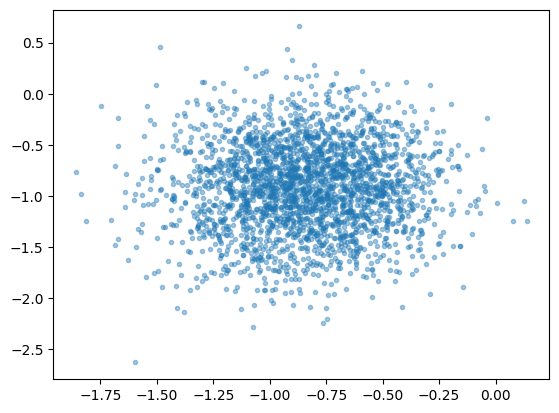

In [7]:
import matplotlib.pyplot as plt

# ode_targ = results_dict["aug_ode"][:, -1,:2]
sde_targ = results_dict["aug"][:, -1,:2]

# plt.plot(ode_targ[:, 0], ode_targ[:, 1], ".", alpha=0.4)
plt.plot(sde_targ[:, 0], sde_targ[:, 1], ".", alpha=0.4)

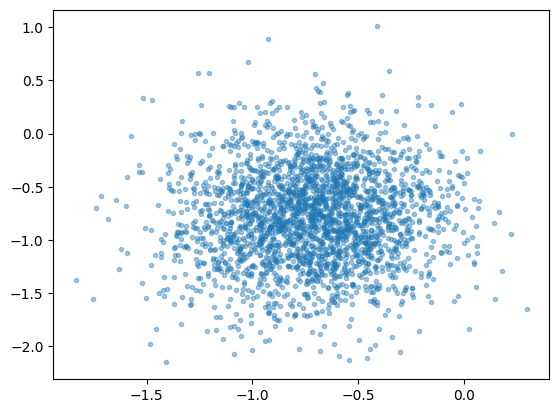

In [8]:
timestep = 90

sde_targ2 = results_dict["aug"][:, timestep,:2]

# plt.plot(ode_targ[:, 0], ode_targ[:, 1], ".", alpha=0.4)
plt.plot(sde_targ2[:, 0], sde_targ2[:, 1], ".", alpha=0.4)

In [9]:
jnp.array(results_dict["is_eval"]).mean()

DeviceArray(109.15314, dtype=float32)

In [10]:
results_dict["is_eval"]

[109.24409484863281,
 107.7279052734375,
 109.0511474609375,
 108.06048583984375,
 110.16839599609375,
 108.92056274414062,
 110.2193374633789,
 109.9826889038086,
 106.34907531738281,
 110.27499389648438,
 109.80191040039062,
 109.64164733886719,
 109.71053314208984,
 110.1775894165039,
 109.2854995727539,
 109.61251068115234,
 109.28275299072266,
 109.25816345214844,
 109.79922485351562,
 110.29537200927734,
 108.24065399169922,
 108.79259490966797,
 108.90299224853516,
 110.36421966552734,
 108.75717163085938,
 107.84441375732422,
 108.50138854980469,
 109.90017700195312,
 107.75309753417969,
 108.67316436767578]

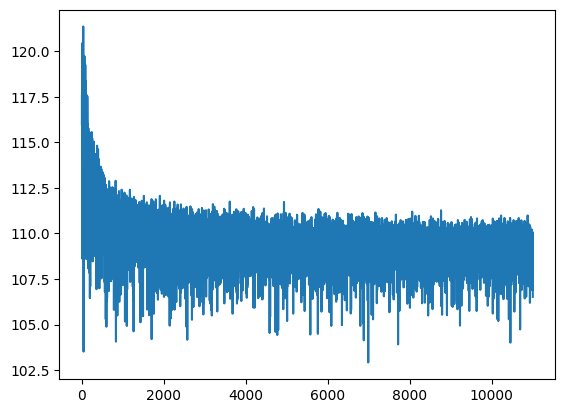

In [11]:
plt.plot(results_dict["is"])

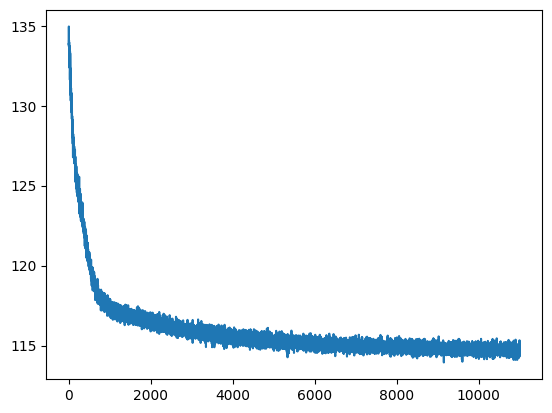

In [12]:
plt.plot(results_dict["elbo"])

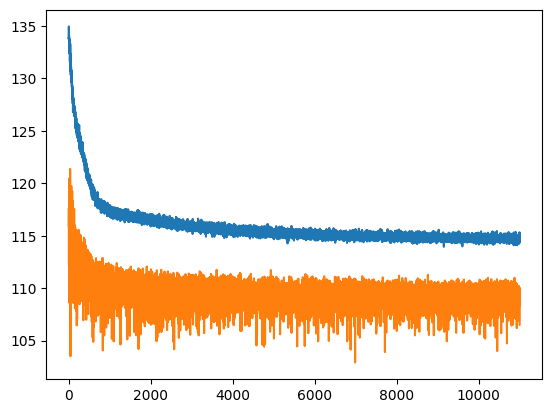

In [13]:
plt.plot(results_dict["elbo"])
plt.plot(results_dict["is"])